In [1]:
%load_ext watermark
# General
import pandas as pd
import numpy as np
import time
import os

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

# Preprocessing
import string
from nltk.tokenize import RegexpTokenizer
# nltk.download('stopwords')
from nltk.corpus import stopwords
# Regualr expression operator
import re
#from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
# Give a sentiment intensity score to sentences
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec
from sklearn import linear_model, metrics, cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

#import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Warning
import warnings
warnings.filterwarnings('ignore')

from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

from nltk.stem.lancaster import LancasterStemmer
# Vs. nltk.stem.PorterStemmer
from nltk.stem.porter import PorterStemmer
%watermark

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/huwei/anaconda/envs/py36/lib/

2018-12-01T15:54:34+08:00

CPython 3.6.7
IPython 6.4.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
%watermark -p matplotlib,numpy,pandas,scipy,seaborn,sklearn

matplotlib 2.2.3
numpy 1.15.1
pandas 0.23.0
scipy 1.1.0
seaborn 0.9.0
sklearn 0.19.1


In [3]:
##############################################################################
# Self-defined functions
##############################################################################
# Define accuracy calculation function
def prediction_error(y, y_hat):
    """
    Calculate prediction accuaracy.
    
    Arguments:
        y  -- np.array / pd.Series
            The original value of the binary dependent variable;
        
        y_hat -- np.array / pd.Series
            The predicted value of the binary dependent variable;
            
    Return:
        error -- float
    """
    error = float(sum(y!=y_hat))/len(y)
    return error

# Generate cross validation error
def logitCV(X, y, Kfolds = 10):
    '''
    Calculate the K-fold cross validation error
    
    Arguments:
        X -- np.array
            The explanatory variables;
        y -- np.array
            The binary dependent variable;
        Kfolds -- integer
            The subsets number in the cross validation, default is 10;
            
    Return:
        cv_error -- float
            Cross validation prediction error;
    '''
    # initialized the container for the out-of-sample prediction  errors
    errors = np.zeros((Kfolds,), dtype = 'float32')
    # split the training data into 'Kfolds' subsets
    obs = len(y)
    training_split = [subset[1] for subset in \
                      cross_validation.KFold(obs, Kfolds, shuffle=True, random_state=1)]
    # Combine n-1 folds
    for i in range(Kfolds):
        test_idx = training_split[i]
        #pdb.set_trace()
        training_idx = [j for j in range(obs) if j not in test_idx]
        # logistic regression
        clf = linear_model.LogisticRegression()
        # fit the model
        clf.fit(X[training_idx], y[training_idx])
        # make prediction
        y_hat = clf.predict(X[test_idx,])
        errors[i] = prediction_error(y[test_idx], y_hat)
        
    cv_error = np.mean(errors)
    
    return cv_error

# Define the cross validation function for LDA
def ldaCV(texts, sentiment, n_topics):
    """
    Define the cross validation function for LDA
    
    Arguments:
        texts -- list
            The preprocessed texts;
        sentiment -- pandas.core.series.Series
            The sentiment of the text;
        n_topics -- numpy.ndarray
            The array of the number of topics for LDA;
            
    Return:
        n_topics[idx] -- numpy.int64
            Number of topics for LDA with lowest cross-validation error;
        best_lda -- gensim.models.ldamodel.LdaModel
            The LDA model with lowest cross-validation error;
        cv_errors -- numpy.ndarray
            The array of cross-validation error using different number of topics;
    """
    # Create dictionary
    dictionary = Dictionary(texts) 
    # convert text to BoW format corpus
    corpus = [dct.doc2bow(text) for text in texts]  
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    cv_errors = np.zeros((len(n_topics),), dtype = 'float32')
    lda = []
    for i in range(len(n_topics)):
        lda.append(models.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = n_topics[i]))
        corpus_lda = lda[i][corpus_tfidf]
        matrix_lda = np.transpose(matutils.corpus2dense(corpus_lda, num_terms = n_topics[-1]))
        cv_errors[i] = logitCV(matrix_lda, sentiment)
        print('Number of topics:', n_topics[i], '; Cross validation error:', cv_errors[i])
        
    # Find the index for the smallest cv_errors
    val,idx = min((val,idx) for (idx, val) in enumerate(cv_errors))
    # Return the number of optimal corpus and the corresponding lda model 
    return n_topics[idx], lda[idx], cv_errors

#
def preprocessing(data):
    """
    Preprocess the textual data
    
    Arguments:
    data -- pandas.core.series.Series
        The texts data which need to be preprocessed;
        
    Return:
    words -- list
        list of all the preprocessed words in data;
    """
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    words = [st.stem(w) for w in words] #4
    return words

def get_ngrams(text, n):
    """
    Return the ngrams generated from a sequence of items, as an iterator.
    
    For example:
    >>> from nltk.util import ngrams
    >>> list(ngrams([1,2,3,4,5], 3))
    [(1, 2, 3), (2, 3, 4), (3, 4, 5)]
    
    Argument:
    texts -- pandas.core.series.Series
        The textual data;
    n -- int
        The number of ngrams;
    
    Return -- list
        list of all the ngrams of the data;
    """
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    """
    Get the frequency of ngrams in text data;
    
    Argument:
    text --
    n --
    num --
    
    Return:
    
    """
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [4]:
##############################################################################
path_save_fig = os.path.join(os.getcwd(), 'Images')
path_save_data = os.path.join(os.getcwd(), 'Data')

##############################################################################
#### Read Data
##############################################################################
df = pd.read_csv(os.path.join(path_save_data,'Womens Clothing E-Commerce Reviews.csv')).fillna(' ')
print(df.columns)
print(df.index)
print(df.shape)


Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')
RangeIndex(start=0, stop=23486, step=1)
(23486, 11)


In [5]:
##############################################################################
#### Data Preprocessing
##############################################################################
pdtextpreprocess = df[['Title', 'Review Text', 'Rating']]

pdtextpreprocess['index'] = pdtextpreprocess.index

documents = pdtextpreprocess['Review Text']

# print
print(documents.shape)
word_tokenize(documents[0])
PorterStemmer().stem(word_tokenize(documents[0])[0])
type(stopwords)

(23486,)


nltk.corpus.util.LazyCorpusLoader

In [6]:
#####################
# Text tokenized -- Unigram
print('Text Tokenization...')
t1 = time.time()
text_tokenized = [[word.lower() for word in word_tokenize(document)] \
                   for document in documents]
print('Time used: %s seconds' % (time.time()-t1))

Text Tokenization...
Time used: 22.734501838684082 seconds


In [7]:
#####################
# move stopwords
print('Removing Stopwords...')
t1 = time.time()
text_filtered_stopwords = [[word for word in document if not word in stopwords.words('english')]\
                           for document in text_tokenized]
print('Time used: %s seconds' % (time.time()-t1))
print('Length: %s' % len(text_filtered_stopwords))

Removing Stopwords...
Time used: 311.3069968223572 seconds
Length: 23486


In [9]:
#####################
# Removing English Punctuation
print('Removing English Punctuation...')
t1 = time.time()
english_punctuations = string.punctuation
texts_filtered = [[word for word in document if not word in english_punctuations] for document in text_filtered_stopwords]
print('Time used: %s seconds' % (time.time()-t1))
print('Length %s' % len(texts_filtered))

Removing English Punctuation...
Time used: 0.2765049934387207 seconds
Length 23486


In [10]:
#####################
# Stemming
print('Stemming...')
st = PorterStemmer()
t1 = time.time()
texts_stemmed = [[st.stem(word) for word in document] for document in texts_filtered]
print('Time used: %s seconds' % (time.time()-t1))
print('Length %s' % len(texts_stemmed))

print(texts_filtered[0])
print(texts_stemmed[0])

# list of all stems
all_stems = sum(texts_stemmed, [])
type(all_stems)
len(all_stems)

# count() method counts how many times an element has occurred in a list and returns it.
# set of all stems that appears only once
once_stems = set(stem for stem in set(all_stems) if all_stems.count(stem) == 1)
type(once_stems)
len(once_stems)

Stemming...
Time used: 20.053975820541382 seconds
Length 23486
['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable']
['absolut', 'wonder', 'silki', 'sexi', 'comfort']


7839

In [11]:
#####################
#Removing the low frequence word (such as occurence equals one)
texts = [[stem for stem in text if stem not in once_stems] for text in texts_stemmed]
type(texts)
len(texts)

23486

In [12]:
##############################################################################
# Extracting topics and calculating texts correlation
##############################################################################
# Create dictionary
dct = Dictionary(texts) 
# convert text to BoW format corpus
corpus = [dct.doc2bow(text) for text in texts] 
# 
for cp in corpus[:1]:
    for id, freq in cp:
        print(dct[id],',', freq)
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
type(corpus_tfidf)
for cp in corpus_tfidf[:1]:
    for id, freq in cp:
        print(dct[id],',', freq)

2018-12-01 16:12:10,987 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-12-01 16:12:11,516 : INFO : adding document #10000 to Dictionary(6031 unique tokens: ['absolut', 'comfort', 'sexi', 'silki', 'wonder']...)
2018-12-01 16:12:12,049 : INFO : adding document #20000 to Dictionary(6828 unique tokens: ['absolut', 'comfort', 'sexi', 'silki', 'wonder']...)
2018-12-01 16:12:12,221 : INFO : built Dictionary(6889 unique tokens: ['absolut', 'comfort', 'sexi', 'silki', 'wonder']...) from 23486 documents (total 680576 corpus positions)
2018-12-01 16:12:13,439 : INFO : collecting document frequencies
2018-12-01 16:12:13,440 : INFO : PROGRESS: processing document #0
2018-12-01 16:12:13,538 : INFO : PROGRESS: processing document #10000
2018-12-01 16:12:13,631 : INFO : PROGRESS: processing document #20000
2018-12-01 16:12:13,669 : INFO : calculating IDF weights for 23486 documents and 6888 features (610752 matrix non-zeros)


absolut , 1
comfort , 1
sexi , 1
silki , 1
wonder , 1
absolut , 0.3737423347857016
comfort , 0.2244287454373877
sexi , 0.5253917570308515
silki , 0.5852463877033008
wonder , 0.4374912258944229


In [13]:
# =============================================================================
# Latent Semantic Indexing
# Training lsi model
lsi = models.LsiModel(corpus_tfidf, id2word = dct, num_topics = 100)

# Map the document to the topic space to see the correlation between the document and topic
corpus_lsi = lsi[corpus_tfidf]

2018-12-01 16:13:56,002 : INFO : using serial LSI version on this node
2018-12-01 16:13:56,006 : INFO : updating model with new documents
2018-12-01 16:14:01,349 : INFO : preparing a new chunk of documents
2018-12-01 16:14:01,616 : INFO : using 100 extra samples and 2 power iterations
2018-12-01 16:14:01,617 : INFO : 1st phase: constructing (6889, 200) action matrix
2018-12-01 16:14:02,228 : INFO : orthonormalizing (6889, 200) action matrix
2018-12-01 16:14:03,107 : INFO : 2nd phase: running dense svd on (200, 20000) matrix
2018-12-01 16:14:03,771 : INFO : computing the final decomposition
2018-12-01 16:14:03,774 : INFO : keeping 100 factors (discarding 30.790% of energy spectrum)
2018-12-01 16:14:03,803 : INFO : processed documents up to #20000
2018-12-01 16:14:03,808 : INFO : topic #0(25.156): 0.197*"dress" + 0.157*"top" + 0.156*"size" + 0.145*"love" + 0.142*"fit" + 0.135*"'s" + 0.135*"great" + 0.134*"look" + 0.127*"n't" + 0.127*"wear"
2018-12-01 16:14:03,810 : INFO : topic #1(10.262

In [49]:
with open(os.path.join(path_save_data,'lsi_topics.csv'), 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['num','coordinate'])
    for row in lsi.show_topics(num_words=10):
        wr.writerow(row)

In [53]:
# =============================================================================
query = "good dress"

# Change query word to vector
query_bow = dct.doc2bow(query.lower().split())
print(query_bow)
# Mapping query word to 100 dimensional topic space with LSI model
query_lsi = lsi[query_bow]
for idx, val in enumerate(query_lsi):
        print(val[0], ',', val[1])

[(12, 1), (292, 1)]
0 , 0.2597451216880634
1 , -0.007179846354545806
2 , 0.7135802777619947
3 , -0.22213995525109925
4 , 0.12570853884717148
5 , -0.05027291292138286
6 , -0.013888881564987427
7 , -0.19047555222888107
8 , -0.1253394376424704
9 , -0.07907645229378518
10 , 0.1311759047116133
11 , 0.1744602269187831
12 , 0.011936788141705432
13 , -0.03030542983016885
14 , -0.07590061642345333
15 , -0.023241280734357012
16 , -0.11757678777398449
17 , -0.12651375739175358
18 , 0.010191109962758092
19 , 0.06055425111041164
20 , 0.024422616650107018
21 , -0.06769830480286111
22 , 0.14870097681669867
23 , -0.2710367018872947
24 , -0.017808962964315764
25 , -0.03368199810791431
26 , -0.006797680841661682
27 , 0.08290296559152197
28 , -0.053422817290782305
29 , 0.18873937429062554
30 , -0.03478924612883459
31 , -0.04048204991981557
32 , 0.14726067844555382
33 , 0.06488469254304208
34 , 0.11583866542532752
35 , 0.17009709819819405
36 , 0.14476389973464293
37 , -0.07421946774721602
38 , 0.007591940

In [52]:
import csv

with open(os.path.join(path_save_data,'query_lsi.csv'), 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['num','coordinate'])
    for row in query_lsi:
        wr.writerow(row)

In [62]:
# Calculate the cosine similarity/correlation degree btw documents and query word
index = similarities.MatrixSimilarity(corpus_lsi)
sims = index[query_lsi]
#print(list(enumerate(sims)))
# Output sorted results
sort_sims = sorted(enumerate(sims), key = lambda item:-item[-1])
top10 = sort_sims[:10]
top10doc = [documents[j[0]] for j in top10]

print(top10doc)

2018-12-01 16:49:16,950 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2018-12-01 16:49:22,798 : INFO : creating matrix with 23486 documents and 100 features


['This dress is adorable. dress it up or dress it down', 'This is awesome multi-season dress.', "I love the swing and the pretty color of the dress. it's fun to dress up or dress down. the fabric is a little thin so you will need good undergarments if you have lumps and bumps.", 'Horrible fit. i do not understand why they but a aline dress with a skin non aline camisole under the dress.', "This dress is a good casual summer dress. the material is thin and feels nice on. the dress was very wrinkled when it arrived but that came out very easily and the fabric doesn't really wrinkle easily after initial wash and steam. the color is very vibrant and the fit is loose. however, if you have a larger chest (i'm a 34c), the hook and eye closure dones come undone. overall a good purchase. it looks good with a belt as well.", 'Good quality; casual feel good dress. it can be worn as dress, or as tunic over the pants.', 'I love this dress .\r\nperfect fit and very good quality.', "As the previous r

In [63]:
with open(os.path.join(path_save_data,'top10.csv'), 'w') as myfile:
    wr = csv.writer(myfile)
    for row in top10:
        wr.writerow(row)

In [72]:
top10doc[6]

'I love this dress .\r\nperfect fit and very good quality.'

In [69]:
with open(os.path.join(path_save_data,'top10doc.csv'), 'w') as myfile:
    #wr = csv.writer(myfile,dialect='excel')
    for row in top10doc:
        myfile.write(row)
        myfile.write('\n')

In [81]:
############################
# Train lda model
lda = models.LdaModel(corpus_tfidf, id2word = dct, num_topics = 100)

# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = models.CoherenceModel(model=lda, texts=texts, dictionary=dct, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2018-12-01 17:30:27,676 : INFO : using symmetric alpha at 0.01
2018-12-01 17:30:27,677 : INFO : using symmetric eta at 0.01
2018-12-01 17:30:27,681 : INFO : using serial LDA version on this node
2018-12-01 17:30:27,810 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:30:29,905 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:30:31,413 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:30:31,623 : INFO : topic #73 (0.010): 0.010*"color" + 0.009*"work" + 0.008*"love" + 0.008*"omg" + 0.008*"one" + 0.007*"dress" + 0.007*"nice" + 0.007*"belt" + 0.007*"crop" + 0.007*"style"
2018-12-01 17:30:31,627 : INFO : topic #36 (0.010): 0.011*"initi" + 0.010*"season" + 0.010*"attract" + 0.010*"muumuu" + 0.009*"cozi" + 0.009*"re

2018-12-01 17:30:41,318 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:30:42,560 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:30:42,728 : INFO : topic #37 (0.010): 0.054*"silk" + 0.038*"pick" + 0.025*"v-neck" + 0.025*"25" + 0.021*"downsid" + 0.021*"beyond" + 0.019*"tag" + 0.018*"tricki" + 0.016*"support" + 0.015*"manag"
2018-12-01 17:30:42,730 : INFO : topic #36 (0.010): 0.037*"cheap" + 0.033*"attract" + 0.026*"travel" + 0.026*"taller" + 0.025*"capri" + 0.024*"expens" + 0.022*"impress" + 0.022*"thank" + 0.022*"proport" + 0.020*"initi"
2018-12-01 17:30:42,731 : INFO : topic #96 (0.010): 0.073*"linen" + 0.051*"point" + 0.041*"set" + 0.031*"go-to" + 0.029*"prefer" + 0.027*"chanc" + 0.027*"apart" + 0.026*"a-lin" + 0.023*"squar" + 0.022*"took"
2018-12-01 17:30:42,733 : INFO : topic #29 (0.010): 0.026*"gotten" + 0.018*"unless" + 0.014*"natur" + 0.013*"looser" + 0.013*"rack" + 0.012*"snug" + 0.011*"size" + 0.011*"pricey" + 0.011


Perplexity:  -16.620330136476642


2018-12-01 17:32:50,364 : INFO : serializing accumulator to return to master...
2018-12-01 17:32:50,386 : INFO : accumulator serialized
2018-12-01 17:32:50,468 : INFO : serializing accumulator to return to master...
2018-12-01 17:32:50,604 : INFO : serializing accumulator to return to master...
2018-12-01 17:32:50,617 : INFO : accumulator serialized
2018-12-01 17:32:50,491 : INFO : accumulator serialized
2018-12-01 17:33:01,403 : INFO : 3 accumulators retrieved from output queue
2018-12-01 17:33:07,108 : INFO : accumulated word occurrence stats for 22641 virtual documents



Coherence Score:  0.3611225796560708


In [83]:
query_lda = lda[query_bow]
with open(os.path.join(path_save_data,'query_lsi.csv'), 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['num','coordinate'])
    for row in query_lda:
        wr.writerow(row)

In [84]:
with open(os.path.join(path_save_data,'lda_topics.csv'), 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['num','coordinate'])
    for row in lda.show_topics(num_topics=100, num_words=10):
        wr.writerow(row)

In [26]:
 # Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_tfidf, dct)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
75     0.134823  0.042800       1        1  1.947182
4      0.066852 -0.129155       2        1  1.810941
17     0.104282  0.036038       3        1  1.770733
56     0.136767  0.049780       4        1  1.699208
65     0.132657  0.044864       5        1  1.686929
55     0.092648  0.014542       6        1  1.628944
96     0.089643  0.009467       7        1  1.594745
36     0.093095 -0.020416       8        1  1.590336
20     0.098838 -0.047433       9        1  1.585167
74     0.096947  0.020771      10        1  1.499344
10     0.084056 -0.064018      11        1  1.454642
12     0.067142 -0.104547      12        1  1.447435
71     0.082144 -0.014915      13        1  1.438014
57     0.105649  0.051795      14        1  1.435055
62     0.104601  0.035003      15        1  1.405335
93     0.082645 -0.019751      16        1  1.397015
7      0.109460  0.050760      17        1  1.385166
45     0.071715  0.002385      18        1  1.381419
58     0.022975 -0.168650      19        1  1.323892
61     0.065696  0.022207      20        1  1.314272
50     0.006764 -0.130562      21        1  1.284356
89     0.066632 -0.019903      22        1  1.278219
47     0.066752  0.081774      23        1  1.275516
31     0.016869 -0.014239      24        1  1.264490
70     0.060849 -0.064514      25        1  1.236352
79     0.019010 -0.159365      26        1  1.227893
11     0.064347 -0.037699      27        1  1.213717
84     0.063317 -0.006901      28        1  1.213625
9      0.023709 -0.038953      29        1  1.182813
8      0.055740 -0.000595      30        1  1.182011
...         ...       ...     ...      ...       ...
76    -0.044246  0.031929      71        1  0.755433
19    -0.029260 -0.026623      72        1  0.752854
22     0.020597 -0.019668      73        1  0.752140
53    -0.171469 -0.049649      74        1  0.741207
14    -0.126921 -0.020895      75        1  0.715004
40     0.009910  0.007248      76        1  0.713050
64    -0.045219  0.034598      77        1  0.708219
60    -0.003883  0.049990      78        1  0.707606
23    -0.052612 -0.000116      79        1  0.693692
6     -0.011679  0.034920      80        1  0.670492
46    -0.073341 -0.006843      81        1  0.662962
29    -0.097928 -0.033737      82        1  0.654484
44     0.002994  0.045374      83        1  0.647947
15    -0.086268 -0.037769      84        1  0.641742
77    -0.036795  0.085874      85        1  0.638792
3     -0.131823 -0.098030      86        1  0.631378
0     -0.143471  0.048185      87        1  0.627254
52    -0.141411  0.049422      88        1  0.625710
25    -0.151400  0.079251      89        1  0.606428
27    -0.090408 -0.013395      90        1  0.597852
28    -0.077396  0.069206      91        1  0.594596
87    -0.088352  0.084143      92        1  0.589955
86    -0.222025 -0.019402      93        1  0.571033
63    -0.201852 -0.042688      94        1  0.570186
21    -0.089559 -0.000295      95        1  0.565513
67    -0.112212  0.014781      96        1  0.556601
94    -0.157154  0.013796      97        1  0.496834
35    -0.045139 -0.019931      98        1  0.487548
82    -0.241060  0.114068      99        1  0.486302
69    -0.079515  0.062378     100        1  0.484698

[100 rows x 5 columns], topic_info=      Category        Freq        Term       Total  loglift  logprob
term                                                                
525    Default   97.000000  embroideri   97.000000  30.0000  30.0000
698    Default   76.000000     t-shirt   76.000000  29.0000  29.0000
71     Default  187.000000  compliment  187.000000  28.0000  28.0000
587    Default  160.000000        wash  160.000000  27.0000  27.0000
662    Default   77.000000        stun   77.000000  26.0000  26.0000
331    Default   94.000000         new   94.000000  25.0000  25.0000
1129   Default   85.000000        suit   8

In [27]:
pyLDAvis.save_html(vis, 'lda.html')

In [29]:
# ELI5
vect = TfidfVectorizer()
vect.fit(df["Review Text"])
X = vect.transform(df["Review Text"])
y = df["Recommended IND"].copy()
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

target_names = ["Not Recommended","Recommended"]
el = eli5.show_weights(model, vec=vect, top=100, target_names=target_names)

In [67]:
display(el)

Weight?,Feature
+5.064,love
+4.911,perfect
+4.344,little
+4.072,comfortable
+3.551,great
+3.376,with
+3.341,fits
+3.229,soft
+3.138,compliments
+3.048,bit


In [68]:
with open('eli5_predict.html', 'w') as f:
    for iteration in range(15):
        samp = random.randint(1,df.shape[0])
        print("Real Label: {}".format(df["Recommended IND"].iloc[samp]))
        el2 = eli5.show_prediction(model,df["Review Text"].iloc[samp], vec=vect,
                             target_names=target_names)
        display(el2)
        html = el2.data
        f.write(html)

Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 0


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 0


Real Label: 1


In [66]:
from IPython.core.display import HTML
html = el.data
with open('eli5_topfeature.html', 'w') as f:
    f.write(html)

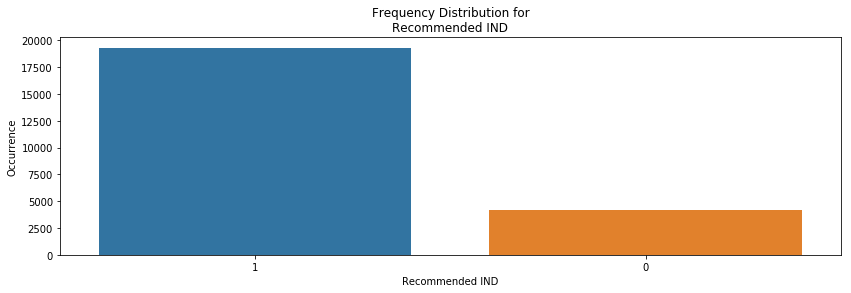

In [74]:
###########################
# Sentiment
sentiment = df['Recommended IND']
#
f, axes = plt.subplots(1,1, figsize=(14,4), sharex=False)
sns.countplot(x='Recommended IND', data=df,order=sentiment.value_counts().index)
axes.set_title("Frequency Distribution for\nRecommended IND")
axes.set_ylabel("Occurrence")
axes.set_xlabel('Recommended IND')
fig = plt.gcf()
fig.savefig(os.path.join(path_save_fig,'RecommendedIND.png'))
plt.show()

In [ ]:
# Cross-validation of LDA
print('Cross-Validation...')
t1 = time.time()
[best_topic, best_lda, cv_errors] = ldaCV(texts, sentiment, n_topics = np.linspace(5,100,20).astype(int))
print('Time used: %s seconds' % (time.time()-t1))
# Save model to disk
best_lda.save(os.path.join(path_save_data,'best_lda'))

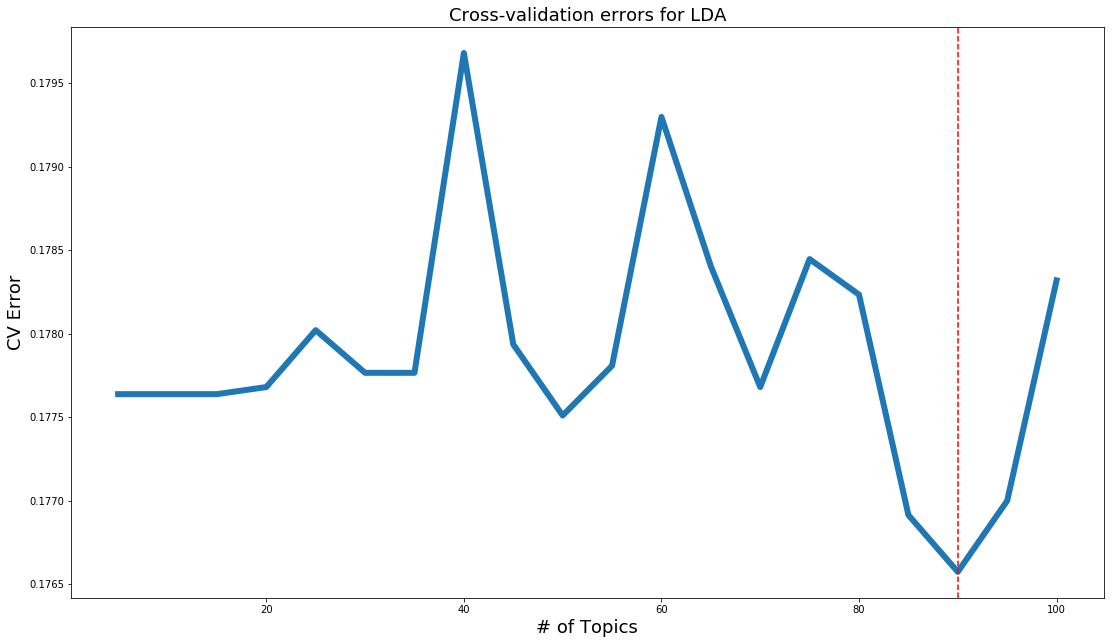

In [36]:
# Save error
np.savetxt(os.path.join(path_save_data,"cv_errors.csv"), cv_errors, delimiter=",")
# Svae figure
plt.figure()
plt.plot(np.linspace(5,100,20).astype(int), cv_errors, linewidth = 6)
plt.axvline(x = best_topic, color = 'r', linestyle = '--')
plt.xlabel('# of Topics', fontsize = 18)
plt.ylabel('CV Error', fontsize = 18)
plt.title('Cross-validation errors for LDA', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5,10.5,5)
fig.savefig(os.path.join(path_save_fig, 'cv_errors.png'))

In [56]:
#######################
# Gram Table
# Recommended
Recommended_gramtab = gram_table(data= documents[df["Recommended IND"].astype(int) == 0], gram=[1,2,3], length=20)
Recommended_gramtab.to_csv(os.path.join(path_save_data, 'Recomended_Gram_Tab.csv'))
#
NotRecommended_gramtab = gram_table(data= documents[df["Recommended IND"].astype(int) == 1], gram=[1,2,3], length=20)
NotRecommended_gramtab.to_csv(os.path.join(path_save_data, 'NotRecomended_Gram_Tab.csv'))


In [57]:
Recommended_gramtab

,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence
0,look,2412,look like,479,realli want love,72
1,dress,2132,go back,273,want love dress,67
2,like,1958,want love,254,realli want like,42
3,fit,1715,realli want,162,fit true size,40
4,top,1713,love dress,136,made look like,30
5,size,1594,made look,136,want love top,29
6,love,1474,5 4,113,make look like,28
7,would,1348,make look,111,look like matern,28
8,fabric,1267,felt like,109,sadli go back,28
9,color,1061,usual wear,104,look like wear,27


In [58]:
NotRecommended_gramtab

,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence
0,dress,10055,true size,1246,fit true size,460
1,love,9921,fit perfectli,1038,run true size,195
2,fit,9797,look great,907,receiv mani compliment,170
3,size,9127,love dress,792,love love love,139
4,wear,7049,look like,676,small fit perfectli,138
5,look,6942,5 4,622,fit like glove,130
6,top,6662,love top,602,usual wear size,109
7,color,6239,usual wear,592,order usual size,93
8,like,5917,fit well,572,run littl big,89
9,great,5587,fit great,559,look great jean,88


In [75]:
##########################################################
# Creating Bigrams and Trigrams Models, higher threshold fewer phrases
##########################################################
print('Creating Bigrams Model...')
# Build the bigram models
t1 = time.time()
bigram = models.Phrases(texts, min_count=1, threshold=1) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = models.phrases.Phraser(bigram)
print('Time used: %s seconds' % (time.time()-t1))
# See example
print(bigram_mod[texts[9]])
texts_bigram = bigram_mod[texts]
#####################

2018-12-01 17:07:15,454 : INFO : collecting all words and their counts
2018-12-01 17:07:15,456 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


Creating Bigrams Model...


2018-12-01 17:07:16,359 : INFO : PROGRESS: at sentence #10000, processed 287419 words and 131933 word types
2018-12-01 17:07:17,459 : INFO : PROGRESS: at sentence #20000, processed 579748 words and 214927 word types
2018-12-01 17:07:17,818 : INFO : collected 239289 word types from a corpus of 680576 words (unigram + bigrams) and 23486 sentences
2018-12-01 17:07:17,820 : INFO : using 239289 counts as vocab in Phrases<0 vocab, min_count=1, threshold=1, max_vocab_size=40000000>
2018-12-01 17:07:17,821 : INFO : source_vocab length 239289
2018-12-01 17:07:21,328 : INFO : Phraser built with 30040 30040 phrasegrams


Time used: 5.88611102104187 seconds
["'m_5", "''", '5_125', 'lb_order', 'petit', 'make_sure', 'length', "n't", 'long', 'typic_wear', 'xs_regular', 'retail', 'dress', "'re_less", 'busti', '34b_cup', 'smaller', 'petit_fit', 'perfectli_snug', 'tight', 'love', 'could', 'dress', 'parti_work', 'love', 'tull', 'longer', 'fabric', 'underneath']


2018-11-29 01:17:28,723 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


Cross-Validation...


2018-11-29 01:17:30,249 : INFO : adding document #10000 to Dictionary(26306 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...)
2018-11-29 01:17:31,694 : INFO : adding document #20000 to Dictionary(33624 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...)
2018-11-29 01:17:32,209 : INFO : built Dictionary(34708 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...) from 23486 documents (total 486316 corpus positions)
2018-11-29 01:17:35,101 : INFO : collecting document frequencies
2018-11-29 01:17:35,102 : INFO : PROGRESS: processing document #0
2018-11-29 01:17:35,144 : INFO : PROGRESS: processing document #10000
2018-11-29 01:17:35,211 : INFO : PROGRESS: processing document #20000
2018-11-29 01:17:35,241 : INFO : calculating IDF weights for 23486 documents and 6888 features (271586 matrix non-zeros)
2018-11-29 01:17:35,283 : INFO : using symmetric alpha at 0.2
2018-11-29 01:17:35,284 : INFO : using symmetric eta a

2018-11-29 01:17:41,231 : INFO : PROGRESS: pass 0, at document #12000/23486
2018-11-29 01:17:41,997 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:17:42,023 : INFO : topic #0 (0.200): 0.008*"knee" + 0.005*"noth" + 0.004*"flirti" + 0.004*"medium_ok." + 0.004*"petit" + 0.004*"get" + 0.004*"love_color" + 0.003*"realli_nice" + 0.003*"run_littl" + 0.003*"embellish"
2018-11-29 01:17:42,024 : INFO : topic #1 (0.200): 0.006*"knee" + 0.005*"noth" + 0.004*"petit" + 0.004*"love_traci" + 0.003*"bottom_half" + 0.003*"stranger" + 0.003*"flirti" + 0.003*"mainli" + 0.003*"alreadi_sold" + 0.003*"medium_ok."
2018-11-29 01:17:42,026 : INFO : topic #2 (0.200): 0.006*"knee" + 0.004*"medium_ok." + 0.003*"petit" + 0.003*"noth" + 0.003*"pant" + 0.003*"flirti" + 0.003*"alreadi_sold" + 0.002*"bc" + 0.002*"embellish" + 0.002*"almost_alway"
2018-11-29 01:17:42,029 : INFO : topic #3 (0.200): 0.007*"knee" + 0.007*"petit" + 0.006*"noth" + 0.005*"medium_ok." + 0.005*"..." +

2018-11-29 01:17:47,528 : INFO : topic #4 (0.200): 0.012*"knee" + 0.011*"noth" + 0.011*"petit" + 0.009*"medium_ok." + 0.008*"flirti" + 0.008*"wear_leg" + 0.007*"stranger" + 0.007*"..." + 0.007*"alreadi_sold" + 0.006*"garment"
2018-11-29 01:17:47,531 : INFO : topic diff=0.085456, rho=0.301511
2018-11-29 01:17:48,477 : INFO : -8.942 per-word bound, 491.9 perplexity estimate based on a held-out corpus of 1486 documents with 4431 words
2018-11-29 01:17:48,480 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-11-29 01:17:48,870 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-11-29 01:17:48,895 : INFO : topic #0 (0.200): 0.004*"knee" + 0.003*"noth" + 0.003*"like_model" + 0.003*"question" + 0.002*"front_tie" + 0.002*"fact" + 0.002*"flirti" + 0.002*"petit" + 0.002*"tie_front" + 0.002*"bc"
2018-11-29 01:17:48,897 : INFO : topic #1 (0.200): 0.003*"came_back" + 0.003*"size_normal" + 0.002*"3_month" + 0.002*"knee" + 0.002*"belt_area" + 0.002*"lot_materi" + 

Number of topics: 5 ; Cross validation error: 0.17763777


2018-11-29 01:18:01,908 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:18:02,524 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:18:02,572 : INFO : topic #4 (0.100): 0.008*"knee" + 0.006*"bit_big" + 0.006*"form-fit_fall" + 0.006*"flirti" + 0.005*"noth" + 0.005*"top_half" + 0.005*"bc" + 0.004*"underneath" + 0.004*"embellish" + 0.004*"cardigan"
2018-11-29 01:18:02,573 : INFO : topic #8 (0.100): 0.009*"noth" + 0.007*"petit" + 0.007*"knee" + 0.006*"love_traci" + 0.006*"medium_ok." + 0.006*"underneath" + 0.006*"wear_leg" + 0.005*"stranger" + 0.005*"alreadi_sold" + 0.005*"run_littl"
2018-11-29 01:18:02,575 : INFO : topic #6 (0.100): 0.008*"stranger" + 0.007*"noth" + 0.006*"petit" + 0.006*"wear_leg" + 0.005*"medium_ok." + 0.005*"bc" + 0.004*"flirti" + 0.004*"white_pant" + 0.004*"bit_big" + 0.004*"..."
2018-11-29 01:18:02,577 : INFO : topic #0 (0.100): 0.007*"medium_ok." + 0.007*"knee" + 0.007*"oop" + 0.006*"petit" + 0.006*"get" + 0.

2018-11-29 01:18:07,840 : INFO : topic diff=0.118710, rho=0.408248
2018-11-29 01:18:08,107 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:18:09,043 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:18:09,098 : INFO : topic #3 (0.100): 0.006*"knee" + 0.004*"medium" + 0.004*"hour" + 0.004*"noth" + 0.003*"got_stuck" + 0.003*"'m_5'4" + 0.003*"garment" + 0.003*"felt_like" + 0.003*"flirti" + 0.003*"quirki"
2018-11-29 01:18:09,100 : INFO : topic #1 (0.100): 0.010*"knee" + 0.010*"noth" + 0.007*"stranger" + 0.007*"petit" + 0.006*"love_color" + 0.006*"medium_ok." + 0.006*"bc" + 0.006*"med_fit" + 0.006*"flirti" + 0.005*"garment"
2018-11-29 01:18:09,102 : INFO : topic #5 (0.100): 0.009*"knee" + 0.009*"comfort" + 0.006*"petit" + 0.006*"flirti" + 0.006*"garment" + 0.005*"bit_big" + 0.004*"white_pant" + 0.004*"noth" + 0.004*"..." + 0.004*"medium_ok."
2018-11-29 01:18:09,106 : INFO : topic #7 (0.100): 0.009*"knee" + 0.007*"noth" + 0.006*"main

2018-11-29 01:18:14,896 : INFO : topic #1 (0.100): 0.008*"knee" + 0.008*"noth" + 0.007*"petit" + 0.006*"stranger" + 0.005*"front_tie" + 0.005*"love_color" + 0.005*"alreadi_sold" + 0.005*"medium_ok." + 0.005*"bc" + 0.004*"embellish"
2018-11-29 01:18:14,898 : INFO : topic #4 (0.100): 0.005*"still_recommend" + 0.005*"alon" + 0.004*"add" + 0.004*"tank" + 0.003*"much_bigger" + 0.003*"parka" + 0.003*"wi" + 0.003*"glad_n't" + 0.003*"behind_..." + 0.003*"mud"
2018-11-29 01:18:14,901 : INFO : topic diff=0.063609, rho=0.288675
2018-11-29 01:18:29,936 : INFO : using symmetric alpha at 0.06666666666666667
2018-11-29 01:18:29,937 : INFO : using symmetric eta at 0.06666666666666667
2018-11-29 01:18:29,945 : INFO : using serial LDA version on this node
2018-11-29 01:18:30,020 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a con

Number of topics: 10 ; Cross validation error: 0.17763777


2018-11-29 01:18:30,186 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:18:30,736 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:18:30,811 : INFO : topic #7 (0.067): 0.008*"bit_big" + 0.006*"noth" + 0.006*"never_would" + 0.006*"flirti" + 0.006*"knee" + 0.006*"stranger" + 0.005*"white_pant" + 0.005*"garment" + 0.005*"comfort" + 0.005*"..."
2018-11-29 01:18:30,814 : INFO : topic #2 (0.067): 0.006*"petit" + 0.006*"stranger" + 0.006*"noth" + 0.006*"knee" + 0.005*"averag_height" + 0.005*"..." + 0.005*"flirti" + 0.005*"embellish" + 0.005*"medium_ok." + 0.005*"long"
2018-11-29 01:18:30,816 : INFO : topic #1 (0.067): 0.008*"knee" + 0.008*"cardigan" + 0.007*"petit" + 0.006*"'s_great" + 0.006*"bit_big" + 0.006*"medium_ok." + 0.006*"stranger" + 0.006*"bc" + 0.006*"noth" + 0.006*"garment"
2018-11-29 01:18:30,819 : INFO : topic #12 (0.067): 0.008*"knee" + 0.008*"noth" + 0.007*"mainli" + 0.007*"stranger" + 0.007*"run_littl" + 0.005*"alread

2018-11-29 01:18:35,655 : INFO : topic diff=0.103059, rho=0.408248
2018-11-29 01:18:35,829 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:18:36,413 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:18:36,487 : INFO : topic #2 (0.067): 0.008*"knee" + 0.005*"petit" + 0.005*"flirti" + 0.005*"fabric_felt" + 0.005*"bc" + 0.004*"noth" + 0.004*"embellish" + 0.004*"skirt_flare" + 0.004*"medium_ok." + 0.004*"garment"
2018-11-29 01:18:36,489 : INFO : topic #8 (0.067): 0.007*"definit_run" + 0.006*"30_'s" + 0.006*"design/pattern" + 0.005*"length_perfect" + 0.005*"tri_usual" + 0.005*"slightli_tight" + 0.004*"near" + 0.004*"tight_across" + 0.004*"outfit" + 0.004*"alreadi_worn"
2018-11-29 01:18:36,492 : INFO : topic #1 (0.067): 0.017*"knee" + 0.014*"petit" + 0.012*"medium_ok." + 0.012*"wear_leg" + 0.011*"garment" + 0.011*"comfort" + 0.010*"stranger" + 0.010*"noth" + 0.009*"flirti" + 0.008*"good_length"
2018-11-29 01:18:36,495 : INFO : topic 

2018-11-29 01:18:42,317 : INFO : topic #3 (0.067): 0.005*"dress_beauti" + 0.005*"photograph_model" + 0.004*"wore_busi" + 0.004*"hung" + 0.004*"moss" + 0.004*"look_better" + 0.004*"bodi_type" + 0.004*"petit" + 0.004*"savvi" + 0.004*"especi"
2018-11-29 01:18:42,319 : INFO : topic #14 (0.067): 0.008*"abl_keep" + 0.007*"glad_n't" + 0.007*"said" + 0.007*"wonder_comfort" + 0.006*"deep_forest" + 0.005*"probabl_favorit" + 0.005*"eat" + 0.005*"noth" + 0.005*"side_zipper" + 0.004*"super"
2018-11-29 01:18:42,322 : INFO : topic diff=0.064264, rho=0.288675
2018-11-29 01:18:58,456 : INFO : using symmetric alpha at 0.05
2018-11-29 01:18:58,457 : INFO : using symmetric eta at 0.05
2018-11-29 01:18:58,464 : INFO : using serial LDA version on this node
2018-11-29 01:18:58,574 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a conver

Number of topics: 15 ; Cross validation error: 0.17763777


2018-11-29 01:18:58,753 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:18:59,326 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:18:59,423 : INFO : topic #8 (0.050): 0.008*"oop" + 0.008*"petit" + 0.008*"medium_ok." + 0.007*"knee" + 0.007*"..." + 0.006*"noth" + 0.006*"run_littl" + 0.006*"flirti" + 0.006*"stranger" + 0.006*"alreadi_sold"
2018-11-29 01:18:59,425 : INFO : topic #19 (0.050): 0.011*"noth" + 0.007*"knee" + 0.007*"petit" + 0.006*"love_jumpsuit" + 0.006*"underneath" + 0.006*"flirti" + 0.005*"pant" + 0.005*"wear_leg" + 0.005*"perfect" + 0.005*"embellish"
2018-11-29 01:18:59,429 : INFO : topic #10 (0.050): 0.008*"stranger" + 0.007*"bc" + 0.007*"love_traci" + 0.006*"noth" + 0.006*"cardigan" + 0.005*"balanc" + 0.005*"flirti" + 0.005*"bit_big" + 0.005*"length" + 0.005*"petit"
2018-11-29 01:18:59,431 : INFO : topic #5 (0.050): 0.012*"noth" + 0.010*"petit" + 0.007*"garment" + 0.007*"medium_ok." + 0.006*"..." + 0.006*"mom" + 

2018-11-29 01:19:06,143 : INFO : topic diff=0.096816, rho=0.408248
2018-11-29 01:19:06,420 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:19:07,361 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:19:07,477 : INFO : topic #19 (0.050): 0.011*"knee" + 0.007*"petit" + 0.007*"noth" + 0.006*"said" + 0.006*"bc" + 0.006*"medium_ok." + 0.006*"..." + 0.006*"stretch" + 0.006*"hte_color" + 0.006*"stranger"
2018-11-29 01:19:07,479 : INFO : topic #1 (0.050): 0.012*"knee" + 0.008*"includ_work" + 0.007*"flirti" + 0.007*"mainli" + 0.006*"zip" + 0.006*"petit" + 0.006*"medium_ok." + 0.005*"..." + 0.005*"fit_nice" + 0.005*"alreadi_sold"
2018-11-29 01:19:07,481 : INFO : topic #13 (0.050): 0.011*"fit_right" + 0.009*"med_fit" + 0.007*"occas" + 0.007*"shown" + 0.007*"hour" + 0.006*"caught_eye" + 0.006*"order_xsp" + 0.006*"question" + 0.005*"rest" + 0.005*"wi"
2018-11-29 01:19:07,483 : INFO : topic #8 (0.050): 0.010*"knee" + 0.009*"petit" + 0.009*"s

2018-11-29 01:19:14,188 : INFO : topic #4 (0.050): 0.008*"like_model" + 0.006*"insul" + 0.006*"need" + 0.006*"look_polish" + 0.005*"38-30-40" + 0.005*"pinch" + 0.005*"tri_use" + 0.005*"typic_wear" + 0.005*"lb_order" + 0.004*"true_photo"
2018-11-29 01:19:14,192 : INFO : topic #13 (0.050): 0.013*"question" + 0.012*"fit_right" + 0.011*"occas" + 0.008*"caught_eye" + 0.008*"shown" + 0.007*"work_ala" + 0.007*"waist_hem" + 0.006*"difficult_zip" + 0.005*"hem" + 0.005*"look_stylish"
2018-11-29 01:19:14,196 : INFO : topic diff=0.059690, rho=0.288675
2018-11-29 01:19:33,514 : INFO : using symmetric alpha at 0.04
2018-11-29 01:19:33,515 : INFO : using symmetric eta at 0.04
2018-11-29 01:19:33,528 : INFO : using serial LDA version on this node


Number of topics: 20 ; Cross validation error: 0.17763777


2018-11-29 01:19:33,729 : INFO : running online (single-pass) LDA training, 25 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:19:33,979 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:19:34,612 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:19:34,753 : INFO : topic #22 (0.040): 0.009*"noth" + 0.008*"medium_ok." + 0.006*"stranger" + 0.006*"oop" + 0.006*"knee" + 0.005*"alreadi_sold" + 0.005*"mainli" + 0.005*"wear_leg" + 0.005*"bit_big" + 0.005*"sinc"
2018-11-29 01:19:34,755 : INFO : topic #0 (0.040): 0.009*"flirti" + 0.007*"medium_ok." + 0.006*"oop" + 0.006*"noth" + 0.006*"petit" + 0.005*"belli" + 0.005*"embellish" + 0.004*"stranger" + 0.004*"still" + 0.004*"wil"
2018-11-29 01:19:34,757 : INFO : topic #5 (0.040): 0.009*"cardigan" + 0.006*"flirti" + 0.006*"noth

2018-11-29 01:19:39,812 : INFO : topic #1 (0.040): 0.014*"stretch" + 0.009*"type" + 0.009*"could" + 0.009*"tell" + 0.008*"'m_happi" + 0.008*"order_small" + 0.007*"atleast" + 0.007*"waist_hem" + 0.007*"fell_right" + 0.006*"fit_right"
2018-11-29 01:19:39,816 : INFO : topic diff=0.111813, rho=0.408248
2018-11-29 01:19:40,028 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:19:40,660 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:19:40,798 : INFO : topic #22 (0.040): 0.011*"knee" + 0.011*"long" + 0.010*"say" + 0.008*"petit" + 0.007*"line" + 0.006*"wear_leg" + 0.006*"noth" + 0.006*"even" + 0.006*"alreadi_sold" + 0.006*"medium_ok."
2018-11-29 01:19:40,800 : INFO : topic #7 (0.040): 0.014*"knee" + 0.010*"noth" + 0.008*"bc" + 0.008*"medium_ok." + 0.008*"flirti" + 0.007*"alreadi_sold" + 0.007*"boxi" + 0.007*"petit" + 0.007*"oop" + 0.007*"..."
2018-11-29 01:19:40,802 : INFO : topic #15 (0.040): 0.011*"lb_order" + 0.010*"knee" + 0.010*"

2018-11-29 01:19:49,981 : INFO : topic #22 (0.040): 0.013*"long" + 0.011*"say" + 0.010*"knee" + 0.007*"noth" + 0.007*"petit" + 0.006*"wear_leg" + 0.006*"felt_wool" + 0.006*"hte_xs" + 0.006*"embellish" + 0.006*"line"
2018-11-29 01:19:49,983 : INFO : topic #7 (0.040): 0.014*"noth" + 0.012*"knee" + 0.009*"..." + 0.008*"flirti" + 0.008*"medium_ok." + 0.008*"alreadi_sold" + 0.008*"oop" + 0.008*"petit" + 0.008*"like" + 0.007*"bc"
2018-11-29 01:19:49,986 : INFO : topic #18 (0.040): 0.014*"like_model" + 0.014*"size_normal" + 0.010*"support" + 0.010*"dim" + 0.009*"visual_interest" + 0.009*"bought_holli" + 0.008*"tri_use" + 0.008*"total_disagre" + 0.007*"add" + 0.006*"look_stylish"
2018-11-29 01:19:49,988 : INFO : topic #2 (0.040): 0.014*"smaller" + 0.011*"tri_usual" + 0.011*"cut" + 0.010*"wore_busi" + 0.009*"quit_nice" + 0.009*"'m_5'11" + 0.008*"total" + 0.008*"second_tull" + 0.007*"dark_wash" + 0.007*"current"
2018-11-29 01:19:49,994 : INFO : topic diff=0.056472, rho=0.288675
2018-11-29 01:20:

Number of topics: 25 ; Cross validation error: 0.17763777


2018-11-29 01:20:09,453 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:20:10,162 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:20:10,329 : INFO : topic #6 (0.033): 0.009*"noth" + 0.008*"stranger" + 0.007*"'s_great" + 0.007*"underneath" + 0.006*"knee" + 0.006*"leg_open" + 0.006*"petit" + 0.005*"belli" + 0.005*"long" + 0.005*"oop"
2018-11-29 01:20:10,331 : INFO : topic #23 (0.033): 0.013*"knee" + 0.010*"overwhelm_small" + 0.009*"noth" + 0.009*"alreadi_sold" + 0.008*"love_color" + 0.008*"3" + 0.007*"bc" + 0.006*"run_littl" + 0.005*"wil" + 0.005*"underneath"
2018-11-29 01:20:10,334 : INFO : topic #28 (0.033): 0.009*"xs" + 0.009*"love_traci" + 0.009*"'s_great" + 0.008*"..." + 0.006*"light_blue" + 0.005*"white_pant" + 0.005*"bc" + 0.005*"littl_long" + 0.005*"noth" + 0.005*"medium_ok."
2018-11-29 01:20:10,336 : INFO : topic #3 (0.033): 0.009*"petit" + 0.007*"bc" + 0.007*"realli_nice" + 0.007*"emb" + 0.006*"oop" + 0.006*"medium_ok.

2018-11-29 01:20:16,158 : INFO : topic diff=0.101511, rho=0.408248
2018-11-29 01:20:16,372 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:20:17,027 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:20:17,192 : INFO : topic #4 (0.033): 0.013*"stranger" + 0.013*"knee" + 0.012*"flirti" + 0.011*"petit" + 0.010*"perfect" + 0.010*"noth" + 0.010*"wear_leg" + 0.009*"..." + 0.009*"white_pant" + 0.009*"medium_ok."
2018-11-29 01:20:17,194 : INFO : topic #25 (0.033): 0.008*"knee" + 0.007*"med_fit" + 0.007*"cami" + 0.007*"atleast" + 0.006*"..." + 0.006*"make_perfect" + 0.006*"stand" + 0.006*"noth" + 0.006*"short_side" + 0.005*"love_top"
2018-11-29 01:20:17,196 : INFO : topic #16 (0.033): 0.011*"39" + 0.011*"form" + 0.010*"30_'s" + 0.010*"swallow_whole" + 0.010*"graze" + 0.009*"footbal_player" + 0.009*"petit" + 0.009*"return" + 0.007*"store_went" + 0.007*"smaller"
2018-11-29 01:20:17,198 : INFO : topic #13 (0.033): 0.012*"like_model" + 0.01

2018-11-29 01:20:24,372 : INFO : topic #20 (0.033): 0.013*"knee" + 0.009*"peplum" + 0.009*"say" + 0.008*"medium_ok." + 0.008*"comfort" + 0.007*"noth" + 0.007*"alreadi_sold" + 0.007*"..." + 0.006*"snap" + 0.006*"flirti"
2018-11-29 01:20:24,375 : INFO : topic #6 (0.033): 0.012*"0p_brand" + 0.011*"n't_decid" + 0.009*"part" + 0.009*"right" + 0.008*"5'3_''" + 0.008*"knee" + 0.008*"definit_need" + 0.008*"realli_love" + 0.007*"noth" + 0.007*"petit"
2018-11-29 01:20:24,380 : INFO : topic diff=0.056229, rho=0.288675
2018-11-29 01:20:43,873 : INFO : using symmetric alpha at 0.02857142857142857
2018-11-29 01:20:43,874 : INFO : using symmetric eta at 0.02857142857142857
2018-11-29 01:20:43,887 : INFO : using serial LDA version on this node


Number of topics: 30 ; Cross validation error: 0.17763777


2018-11-29 01:20:44,112 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:20:44,412 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:20:45,314 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:20:45,532 : INFO : topic #5 (0.029): 0.010*"noth" + 0.009*"mainli" + 0.005*"make_sure" + 0.005*"whim" + 0.005*"petit" + 0.005*"hour-glass_figur" + 0.005*"run_littl" + 0.005*"petit_small" + 0.005*"oop" + 0.005*"light"
2018-11-29 01:20:45,535 : INFO : topic #20 (0.029): 0.012*"oop" + 0.008*"medium_ok." + 0.008*"mainli" + 0.007*"cardigan" + 0.007*"knee" + 0.007*"noth" + 0.005*"bottom_half" + 0.005*"least" + 0.005*"stranger" + 0.005*"retun"
2018-11-29 01:20:45,537 : INFO : topic #1 (0.029): 0.015*"noth" + 0.008*"flirti" + 0.0

2018-11-29 01:20:52,415 : INFO : topic #9 (0.029): 0.013*"look_someth" + 0.011*"n't_decid" + 0.011*"like_paig" + 0.010*"knee" + 0.009*"sheer" + 0.009*"shopper" + 0.008*"realli_hope" + 0.008*"sale_price" + 0.008*"garment" + 0.008*"dark_blue"
2018-11-29 01:20:52,417 : INFO : topic #20 (0.029): 0.012*"could" + 0.011*"strang_fit" + 0.010*"5_125" + 0.009*"knee" + 0.007*"longer" + 0.006*"'s_lightweight" + 0.006*"nice_stretch" + 0.006*"noth" + 0.006*"due" + 0.005*"tight_waist"
2018-11-29 01:20:52,422 : INFO : topic diff=0.096694, rho=0.408248
2018-11-29 01:20:52,605 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:20:53,202 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:20:53,387 : INFO : topic #5 (0.029): 0.013*"uniqu" + 0.013*"perfectli_snug" + 0.011*"beauti_drape" + 0.010*"outer_fabric" + 0.009*"bought_holli" + 0.009*"unexpect" + 0.009*"get_fact" + 0.008*"quot" + 0.008*"petit_small" + 0.007*"skirt"
2018-11-29 01:20:53,389 : INFO 

2018-11-29 01:20:59,833 : INFO : topic #7 (0.029): 0.027*"im_5'5" + 0.013*"eat" + 0.011*"pooch" + 0.011*"exactli_pictur" + 0.011*"rees_dress" + 0.011*"sale_buy" + 0.010*"probabl_would" + 0.010*"rid" + 0.009*"kiss" + 0.008*"partial_line"
2018-11-29 01:20:59,838 : INFO : topic #34 (0.029): 0.019*"petit" + 0.013*"5'8_140lb" + 0.011*"let" + 0.009*"knee" + 0.009*"second" + 0.008*"tunic" + 0.008*"top_awhil" + 0.008*"onlin" + 0.007*"realli_nice" + 0.007*"new"
2018-11-29 01:20:59,841 : INFO : topic #11 (0.029): 0.021*"boxi" + 0.016*"true_size" + 0.014*"waist" + 0.012*"thin_enough" + 0.011*"size_4" + 0.010*"white_embroideri" + 0.009*"opinion_run" + 0.008*"expect" + 0.008*"'s_huge" + 0.008*"caus"
2018-11-29 01:20:59,843 : INFO : topic #5 (0.029): 0.013*"perfectli_snug" + 0.011*"skirt" + 0.010*"uniqu" + 0.009*"bit_bulki" + 0.009*"quot" + 0.009*"bought_holli" + 0.008*"beauti_drape" + 0.008*"get_fact" + 0.008*"realli" + 0.008*"esp"
2018-11-29 01:20:59,850 : INFO : topic diff=0.059186, rho=0.288675


Number of topics: 35 ; Cross validation error: 0.17763777


2018-11-29 01:21:17,690 : INFO : running online (single-pass) LDA training, 40 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:21:17,882 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:21:18,484 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:21:18,730 : INFO : topic #14 (0.025): 0.008*"knee" + 0.008*"..." + 0.008*"petit" + 0.007*"pant" + 0.007*"hour-glass_figur" + 0.006*"flirti" + 0.006*"least" + 0.005*"mainli" + 0.005*"stranger" + 0.005*"good_length"
2018-11-29 01:21:18,731 : INFO : topic #15 (0.025): 0.007*"love_traci" + 0.007*"run_littl" + 0.006*"medium_ok." + 0.005*"sleev_long" + 0.005*"si_littl" + 0.005*"flatter" + 0.005*"stretchi_comfort" + 0.005*"get" + 0.005*"ladi" + 0.005*"petit"
2018-11-29 01:21:18,734 : INFO : topic #9 (0.025): 0.008*"knee" + 0.007

2018-11-29 01:21:24,393 : INFO : topic #7 (0.025): 0.015*"loos" + 0.012*"stretch" + 0.012*"look_like" + 0.009*"n't_bother" + 0.008*"--" + 0.008*"let" + 0.007*"knee" + 0.007*"'s_sooo" + 0.007*"noth" + 0.007*"never_issu"
2018-11-29 01:21:24,396 : INFO : topic #2 (0.025): 0.012*"petit" + 0.012*"knee" + 0.010*"garment" + 0.010*"embellish" + 0.010*"medium_ok." + 0.009*"noth" + 0.008*"love_traci" + 0.008*"white_pant" + 0.008*"away" + 0.007*"flirti"
2018-11-29 01:21:24,401 : INFO : topic diff=0.104915, rho=0.408248
2018-11-29 01:21:24,613 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:21:25,256 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:21:25,458 : INFO : topic #19 (0.025): 0.020*"coat_alreadi" + 0.015*"style_uniqu" + 0.013*"part" + 0.013*"love_color" + 0.011*"xs" + 0.010*"'s_super" + 0.010*"'m_5" + 0.010*"hte" + 0.010*"felt_like" + 0.009*"awkward_tight"
2018-11-29 01:21:25,460 : INFO : topic #7 (0.025): 0.014*"loos" + 0.013*"

2018-11-29 01:21:32,353 : INFO : topic #31 (0.025): 0.020*"get_away" + 0.018*"would_describ" + 0.013*"keyhol_back" + 0.012*"bonu" + 0.011*"'m_sure" + 0.011*"'s_simpl" + 0.010*"nice_stretch" + 0.010*"longer" + 0.009*"forev" + 0.008*"local_retail"
2018-11-29 01:21:32,355 : INFO : topic #3 (0.025): 0.019*"petit_decid" + 0.019*"balanc" + 0.016*"season_easili" + 0.013*"well_pencil" + 0.010*"snap_took" + 0.009*"dress_simpli" + 0.009*"kind" + 0.009*"come_side" + 0.008*"fantast" + 0.007*"sleev"
2018-11-29 01:21:32,357 : INFO : topic #20 (0.025): 0.016*"white_pant" + 0.013*"knee" + 0.013*"noth" + 0.013*"petit" + 0.011*"tall_long" + 0.011*"medium_ok." + 0.010*"flirti" + 0.010*"..." + 0.010*"comfort" + 0.010*"caus"
2018-11-29 01:21:32,359 : INFO : topic #0 (0.025): 0.020*"whim" + 0.017*"poncho" + 0.016*"said" + 0.015*"abl_keep" + 0.014*"problem" + 0.013*"add" + 0.013*"hung" + 0.012*"tailor" + 0.011*"tell" + 0.010*"swallow_whole"
2018-11-29 01:21:32,365 : INFO : topic diff=0.056569, rho=0.288675
2

Number of topics: 40 ; Cross validation error: 0.17763777


2018-11-29 01:21:50,654 : INFO : running online (single-pass) LDA training, 45 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:21:50,955 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:21:51,669 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:21:51,901 : INFO : topic #9 (0.022): 0.007*"underneath" + 0.007*"white_pant" + 0.007*"stranger" + 0.006*"bc" + 0.006*"comfort" + 0.005*"petit" + 0.005*"wil" + 0.005*"cardigan" + 0.005*"true_size" + 0.005*"go_petit"
2018-11-29 01:21:51,902 : INFO : topic #2 (0.022): 0.012*"medium_ok." + 0.009*"stranger" + 0.008*"flirti" + 0.008*"noth" + 0.008*"petit" + 0.007*"garment" + 0.007*"truli" + 0.006*"pant" + 0.006*"waist" + 0.006*"long"
2018-11-29 01:21:51,905 : INFO : topic #15 (0.022): 0.007*"idea" + 0.007*"alreadi_sold" + 0.007

2018-11-29 01:21:58,078 : INFO : topic #4 (0.022): 0.015*"short_side" + 0.014*"fell_right" + 0.013*"thin_poor" + 0.012*"39" + 0.010*"photo" + 0.009*"silki" + 0.009*"weak" + 0.008*"transit_easili" + 0.008*"need_slip" + 0.008*"massiv"
2018-11-29 01:21:58,088 : INFO : topic diff=0.093714, rho=0.408248
2018-11-29 01:21:58,443 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:21:59,874 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:22:00,132 : INFO : topic #15 (0.022): 0.016*"littl_loos" + 0.014*"true_photo" + 0.013*"get_mani" + 0.012*"line" + 0.011*"still_recommend" + 0.010*"book" + 0.009*"meda_lace" + 0.009*"materi" + 0.009*"super_cozi" + 0.009*"circl_skirt"
2018-11-29 01:22:00,134 : INFO : topic #18 (0.022): 0.025*"front_gap" + 0.021*"navi_blazer" + 0.021*"atleast" + 0.013*"n't" + 0.013*"zipper" + 0.012*"model" + 0.009*"school" + 0.009*"could_also" + 0.008*"..._..." + 0.008*"wear_vest"
2018-11-29 01:22:00,140 : INFO : topic #1 (

2018-11-29 01:22:10,215 : INFO : topic #12 (0.022): 0.026*"xs_regular" + 0.018*"petit_fit" + 0.018*"probabl_favorit" + 0.017*"usual_prefer" + 0.016*"look_like" + 0.012*"ador_top" + 0.012*"paid" + 0.010*"'s_warm" + 0.010*"recent_got" + 0.010*"think"
2018-11-29 01:22:10,217 : INFO : topic #28 (0.022): 0.032*"tall_long" + 0.028*"waist_hem" + 0.017*"quot" + 0.015*"smoothli" + 0.015*"found_fit" + 0.015*"cold_dri" + 0.013*"bought_top" + 0.013*"almost_alway" + 0.012*"due" + 0.011*"'m_happi"
2018-11-29 01:22:10,220 : INFO : topic #10 (0.022): 0.030*"say" + 0.021*"store_final" + 0.020*"fit_right" + 0.020*"135lb" + 0.013*"pair_funki" + 0.011*"smitten" + 0.011*"kind" + 0.010*"vest" + 0.010*"knee" + 0.009*"two_button"
2018-11-29 01:22:10,226 : INFO : topic diff=0.055665, rho=0.288675
2018-11-29 01:22:33,369 : INFO : using symmetric alpha at 0.02
2018-11-29 01:22:33,372 : INFO : using symmetric eta at 0.02
2018-11-29 01:22:33,381 : INFO : using serial LDA version on this node


Number of topics: 45 ; Cross validation error: 0.17763777


2018-11-29 01:22:33,669 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:22:33,902 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:22:34,517 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:22:34,786 : INFO : topic #33 (0.020): 0.009*"petit" + 0.009*"'s_great" + 0.009*"medium_ok." + 0.008*"alreadi_sold" + 0.007*"like" + 0.007*"light" + 0.007*"wil" + 0.006*"embellish" + 0.006*"top_half" + 0.006*"launder_well"
2018-11-29 01:22:34,788 : INFO : topic #47 (0.020): 0.009*"pant" + 0.007*"oop" + 0.007*"bc" + 0.006*"realli_nice" + 0.006*"poofi" + 0.006*"cardigan" + 0.006*"petit" + 0.006*"never_would" + 0.005*"sleeveless" + 0.005*"top_half"
2018-11-29 01:22:34,790 : INFO : topic #30 (0.020): 0.012*"embellish" + 0.011*

2018-11-29 01:22:41,004 : INFO : topic #16 (0.020): 0.024*"long" + 0.015*"realli_hope" + 0.014*"cold_dri" + 0.010*"side_zipper" + 0.009*"white_pant" + 0.008*"warm" + 0.008*"two_layer" + 0.008*"charcoal" + 0.008*"pant_trend" + 0.007*"60_'s"
2018-11-29 01:22:41,007 : INFO : topic #42 (0.020): 0.020*"perfectli_snug" + 0.018*"slightli_tight" + 0.016*"got_stuck" + 0.016*"nice" + 0.014*"nice_choic" + 0.014*"snake" + 0.014*"footbal_player" + 0.010*"front_pleat" + 0.010*"basket" + 0.010*"pinch"
2018-11-29 01:22:41,019 : INFO : topic diff=0.103828, rho=0.408248
2018-11-29 01:22:41,256 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:22:41,991 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:22:42,271 : INFO : topic #30 (0.020): 0.031*"oop" + 0.021*"fell_flat" + 0.018*"tell" + 0.016*"alter_shorten" + 0.014*"averag_height" + 0.014*"hit_littl" + 0.014*"get_fact" + 0.013*"stretch" + 0.013*"caus" + 0.013*"rest"
2018-11-29 01:22:42,273 : INFO

2018-11-29 01:22:52,050 : INFO : topic #46 (0.020): 0.021*"other_mention" + 0.018*"waist_hem" + 0.015*"fabric_thick" + 0.013*"short_side" + 0.013*"appear" + 0.012*"size_4" + 0.012*"one_receiv" + 0.011*"one_piec" + 0.011*"petit" + 0.011*"might_issu"
2018-11-29 01:22:52,052 : INFO : topic #43 (0.020): 0.029*"insul" + 0.020*"alter_length" + 0.015*"shirt" + 0.014*"forev" + 0.014*"much_vibrant" + 0.012*"definit_run" + 0.011*"vest" + 0.010*"someth_keep" + 0.009*"stay_closet" + 0.009*"hous"
2018-11-29 01:22:52,055 : INFO : topic #3 (0.020): 0.035*"bit_bulki" + 0.021*"everi_time" + 0.019*"dress_simpli" + 0.017*"make" + 0.017*"'s_warm" + 0.015*"wider_hip" + 0.014*"sorri" + 0.013*"brand" + 0.013*"wish_would" + 0.012*"'ve_look"
2018-11-29 01:22:52,058 : INFO : topic #31 (0.020): 0.040*"front_tie" + 0.026*"simpl" + 0.024*"happen_see" + 0.024*"love" + 0.020*"good_qualiti" + 0.014*"would_describ" + 0.014*"fact" + 0.012*"absolut_wonder" + 0.012*"dress" + 0.012*"come_side"
2018-11-29 01:22:52,066 : IN

Number of topics: 50 ; Cross validation error: 0.17763777


2018-11-29 01:23:15,448 : INFO : running online (single-pass) LDA training, 55 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:23:15,651 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:23:16,278 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:23:16,566 : INFO : topic #18 (0.018): 0.013*"underneath" + 0.011*"get" + 0.010*"..." + 0.009*"much_vibrant" + 0.007*"realli_nice" + 0.007*"..._.." + 0.007*"white_pant" + 0.007*"tri_store" + 0.006*"textur_pattern" + 0.006*"store_soon"
2018-11-29 01:23:16,568 : INFO : topic #43 (0.018): 0.010*"knee" + 0.008*"sleev_long" + 0.007*"sleev_wide" + 0.007*"love_jumpsuit" + 0.007*"small_bust" + 0.007*"get" + 0.006*"order_onlin" + 0.006*"wear_leg" + 0.006*"'s" + 0.006*"top_half"
2018-11-29 01:23:16,570 : INFO : topic #31 (0.018): 0.

2018-11-29 01:23:22,616 : INFO : topic #10 (0.018): 0.025*"fit_right" + 0.019*"embroid_print" + 0.016*"love_color" + 0.013*"seem_bit" + 0.013*"guess" + 0.012*"rest" + 0.010*"drape_well" + 0.010*"knee" + 0.009*"realli_enjoy" + 0.009*"option"
2018-11-29 01:23:22,619 : INFO : topic #7 (0.018): 0.024*"med_fit" + 0.016*"without" + 0.014*"almost" + 0.013*"store_final" + 0.011*"flirti" + 0.011*"person" + 0.010*"howev" + 0.010*"knee" + 0.009*"xs" + 0.009*"80"
2018-11-29 01:23:22,626 : INFO : topic diff=0.103372, rho=0.408248
2018-11-29 01:23:22,807 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:23:23,354 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:23:23,633 : INFO : topic #38 (0.018): 0.013*"retail_purchas" + 0.013*"hte_color" + 0.012*"5'3_''" + 0.010*"add" + 0.010*"slip" + 0.010*"knee" + 0.009*"exactli_pictur" + 0.009*"bought" + 0.009*"'s_super" + 0.009*"love_traci"
2018-11-29 01:23:23,635 : INFO : topic #53 (0.018): 0.034*"str

2018-11-29 01:23:31,402 : INFO : topic #20 (0.018): 0.019*"5'8_140lb" + 0.019*"might_run" + 0.018*"bit_big" + 0.013*"cold_dri" + 0.011*"knee" + 0.011*"due" + 0.011*"hous" + 0.010*"size" + 0.009*"net" + 0.009*"'m_glad"
2018-11-29 01:23:31,404 : INFO : topic #51 (0.018): 0.036*"waist_hem" + 0.024*"frame" + 0.019*"one_piec" + 0.018*"--" + 0.017*"jean" + 0.016*"onlin_person" + 0.014*"sale_buy" + 0.013*"longer" + 0.013*"nice_stretch" + 0.010*"equal"
2018-11-29 01:23:31,406 : INFO : topic #27 (0.018): 0.032*"could_also" + 0.024*"huge" + 0.023*"feel_cheap" + 0.018*"tank" + 0.017*"pull" + 0.017*"knee_conserv" + 0.017*"mostli" + 0.015*"easi_wear" + 0.013*"wait" + 0.013*"m."
2018-11-29 01:23:31,408 : INFO : topic #6 (0.018): 0.013*"knee" + 0.013*"..._.." + 0.012*"teh_color" + 0.012*"wore" + 0.012*"petit" + 0.011*"similar" + 0.011*"coat_alreadi" + 0.011*"emb" + 0.011*"medium_ok." + 0.010*"noth"
2018-11-29 01:23:31,415 : INFO : topic diff=0.055917, rho=0.288675
2018-11-29 01:23:50,313 : INFO : usi

Number of topics: 55 ; Cross validation error: 0.17763777


2018-11-29 01:23:50,765 : INFO : running online (single-pass) LDA training, 60 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:23:51,379 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:23:52,625 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:23:52,997 : INFO : topic #34 (0.017): 0.010*"knee" + 0.008*"mainli" + 0.007*"still" + 0.007*"medium_ok." + 0.007*"xs_regular" + 0.006*"love" + 0.006*"length" + 0.006*"beauti_color" + 0.006*"5'1_100" + 0.006*"make_sure"
2018-11-29 01:23:52,999 : INFO : topic #26 (0.017): 0.011*"noth" + 0.009*"order_onlin" + 0.009*"medium_ok." + 0.007*"somewhat_cheap" + 0.007*"behind_neck" + 0.007*"go_size" + 0.007*"med_fit" + 0.007*"..." + 0.006*"love_color" + 0.006*"current"
2018-11-29 01:23:53,002 : INFO : topic #57 (0.017): 0.009*"still

2018-11-29 01:23:59,526 : INFO : topic #29 (0.017): 0.018*"'m_sure" + 0.017*"even_pull" + 0.017*"white_jean" + 0.014*"30_'s" + 0.013*"return_im" + 0.013*"new" + 0.011*"beauti_detail" + 0.010*"question" + 0.010*"much_bigger" + 0.009*"shoulder_narrow"
2018-11-29 01:23:59,528 : INFO : topic #38 (0.017): 0.021*"second" + 0.018*"waist" + 0.018*"still_recommend" + 0.016*"pound_small" + 0.012*"sale_price" + 0.011*"bc" + 0.010*"embellish" + 0.010*"size_8" + 0.009*"noth" + 0.009*"alon"
2018-11-29 01:23:59,536 : INFO : topic diff=0.103175, rho=0.408248
2018-11-29 01:23:59,750 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:24:00,331 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:24:00,647 : INFO : topic #29 (0.017): 0.020*"'m_sure" + 0.019*"even_pull" + 0.015*"white_jean" + 0.014*"return_im" + 0.014*"30_'s" + 0.012*"new" + 0.012*"shown" + 0.010*"pretti_disappoint" + 0.010*"question" + 0.008*"shoulder_narrow"
2018-11-29 01:24:00,649 : 

2018-11-29 01:24:10,245 : INFO : topic #1 (0.017): 0.038*"like" + 0.019*"elast_waistband" + 0.015*"still_worth" + 0.015*"perfect" + 0.014*"feel_cheap" + 0.013*"cream" + 0.013*"noth" + 0.012*"onlin_person" + 0.011*"order_xx" + 0.011*"winter_fall"
2018-11-29 01:24:10,247 : INFO : topic #53 (0.017): 0.040*"torso_5'3" + 0.029*"loos" + 0.027*"right_bustlin" + 0.026*"small_bust" + 0.021*"store" + 0.020*"light_blue" + 0.015*"feet_tall" + 0.014*"wore_busi" + 0.014*"net" + 0.014*"cri"
2018-11-29 01:24:10,249 : INFO : topic #30 (0.017): 0.036*"n't_decid" + 0.033*"comfort" + 0.026*"part" + 0.024*"would_describ" + 0.019*"quot" + 0.018*"flare" + 0.018*"snap_took" + 0.017*"caus" + 0.017*"thin_enough" + 0.015*"look_droopi"
2018-11-29 01:24:10,253 : INFO : topic #55 (0.017): 0.021*"oop" + 0.018*"other_mention" + 0.015*"hung" + 0.015*"poofi" + 0.015*"knee" + 0.014*"form-fit_fall" + 0.013*"petit_small" + 0.013*"directli" + 0.012*"noth" + 0.011*"..."
2018-11-29 01:24:10,257 : INFO : topic #38 (0.017): 0.

Number of topics: 60 ; Cross validation error: 0.17763777


2018-11-29 01:24:32,108 : INFO : running online (single-pass) LDA training, 65 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:24:32,361 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:24:33,143 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:24:33,553 : INFO : topic #57 (0.015): 0.008*"love_jumpsuit" + 0.008*"noth" + 0.007*"quit" + 0.007*"tt" + 0.007*"look_pregnant" + 0.007*"tini" + 0.007*"love" + 0.007*"beauti_color" + 0.007*"med_fit" + 0.006*"averag_height"
2018-11-29 01:24:33,555 : INFO : topic #3 (0.015): 0.013*"top_half" + 0.012*"emb" + 0.012*"petit" + 0.008*"flirti" + 0.007*"outer_fabric" + 0.007*"side_garment" + 0.007*"fell_flat" + 0.007*"underneath" + 0.006*"form-fit_fall" + 0.006*"right"
2018-11-29 01:24:33,558 : INFO : topic #21 (0.015): 0.013*"pant

2018-11-29 01:24:40,081 : INFO : topic #63 (0.015): 0.044*"similar" + 0.019*"cut" + 0.018*"brand_alway" + 0.014*"slimmer" + 0.013*"flat_sandal" + 0.013*"ador_top" + 0.012*"pull" + 0.012*"unfortun_return" + 0.011*"stronger" + 0.010*"easili"
2018-11-29 01:24:40,084 : INFO : topic #37 (0.015): 0.021*"n't_decid" + 0.017*"came_back" + 0.014*"love_jumpsuit" + 0.013*"definit_need" + 0.013*"knee" + 0.012*"age-appropri" + 0.012*"30_'s" + 0.012*"medium_ok." + 0.011*"belt" + 0.010*"noth"
2018-11-29 01:24:40,093 : INFO : topic diff=0.107759, rho=0.408248
2018-11-29 01:24:40,390 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:24:41,261 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:24:41,645 : INFO : topic #49 (0.015): 0.029*"tell" + 0.019*"due" + 0.017*"behind_neck" + 0.017*"tunic" + 0.016*"slightli_tight" + 0.013*"125_pound" + 0.013*"get_lot" + 0.013*"petit_5" + 0.013*"onlin_person" + 0.011*"beauti_detail"
2018-11-29 01:24:41,648 : INF

2018-11-29 01:24:55,132 : INFO : topic #25 (0.015): 0.040*"hand-knit" + 0.024*"embroid_print" + 0.022*"zipper" + 0.019*"true_photo" + 0.018*"look_better" + 0.018*"love_dress" + 0.016*"receiv_lot" + 0.014*"order_small" + 0.014*"feel" + 0.013*"think"
2018-11-29 01:24:55,135 : INFO : topic #27 (0.015): 0.037*"fit_right" + 0.031*"mayb" + 0.030*"right_bustlin" + 0.023*"size_chart" + 0.019*"visual_interest" + 0.018*"transit_easili" + 0.014*"ive" + 0.012*"seam" + 0.012*"6_small" + 0.011*"appeal"
2018-11-29 01:24:55,137 : INFO : topic #11 (0.015): 0.032*"made_look" + 0.026*"still_recommend" + 0.024*"knee" + 0.017*"well_pencil" + 0.017*"add" + 0.015*"'m_sure" + 0.015*"flatter" + 0.015*"store_went" + 0.014*"smaller" + 0.014*"fabric_felt"
2018-11-29 01:24:55,141 : INFO : topic #31 (0.015): 0.034*"balanc" + 0.029*"torso_5'3" + 0.028*"petit_would" + 0.027*"paid" + 0.021*"stretch" + 0.020*"much_wider" + 0.019*"problem" + 0.017*"flirti" + 0.014*"5'1_100" + 0.013*"'s_great"
2018-11-29 01:24:55,150 : I

Number of topics: 65 ; Cross validation error: 0.17763777


2018-11-29 01:25:15,947 : INFO : running online (single-pass) LDA training, 70 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:25:16,126 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:25:16,708 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:25:17,057 : INFO : topic #59 (0.014): 0.009*"short_side" + 0.008*"mainli" + 0.008*"regular" + 0.008*"chanc" + 0.008*"beauti_color" + 0.007*"sleev_long" + 0.007*"true_size" + 0.007*"fit_nice" + 0.007*"noth" + 0.007*"super_cute"
2018-11-29 01:25:17,059 : INFO : topic #26 (0.014): 0.016*"bc" + 0.014*"bit_crop" + 0.012*"petit" + 0.011*"flirti" + 0.011*"look" + 0.011*"top_half" + 0.009*"alreadi_sold" + 0.008*"underneath" + 0.008*"wear_leg" + 0.007*"love_traci"
2018-11-29 01:25:17,061 : INFO : topic #60 (0.014): 0.011*"said" + 

2018-11-29 01:25:22,883 : INFO : topic #25 (0.014): 0.018*"jean_pencil" + 0.016*"xs" + 0.014*"white_jean" + 0.014*"noth" + 0.013*"without" + 0.013*"'s_huge" + 0.013*"good_length" + 0.011*"love_traci" + 0.010*"'m_sure" + 0.009*"stranger"
2018-11-29 01:25:22,886 : INFO : topic #40 (0.014): 0.016*"hope_make" + 0.015*"fell_flat" + 0.014*"store_pick" + 0.012*"fabric_start" + 0.011*"two_layer" + 0.011*"med_fit" + 0.010*"flaw" + 0.009*"5'9_height" + 0.008*"felt" + 0.008*"love_jumpsuit"
2018-11-29 01:25:22,894 : INFO : topic diff=0.107345, rho=0.408248
2018-11-29 01:25:23,097 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:25:23,754 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:25:24,122 : INFO : topic #52 (0.014): 0.023*"sleep" + 0.017*"run_big" + 0.017*"skirt_flare" + 0.017*"medium" + 0.014*"tull" + 0.014*"return" + 0.014*"bummer" + 0.013*"tailor" + 0.013*"'m_5'4" + 0.012*"'s_lightweight"
2018-11-29 01:25:24,125 : INFO : topic #4

2018-11-29 01:25:33,123 : INFO : topic #5 (0.014): 0.055*"made_look" + 0.033*"happen_see" + 0.027*"let" + 0.020*"imagin" + 0.017*"miracul" + 0.015*"order_normal" + 0.015*"n't" + 0.013*"'s_slight" + 0.012*"34b_cup" + 0.012*"im"
2018-11-29 01:25:33,125 : INFO : topic #47 (0.014): 0.048*"5'8_140lb" + 0.035*"awkward_tight" + 0.035*"petit_fit" + 0.018*"summer" + 0.017*"tri_use" + 0.015*"much_vibrant" + 0.014*"moss" + 0.013*"huge" + 0.012*"vest" + 0.011*"two_button"
2018-11-29 01:25:33,127 : INFO : topic #1 (0.014): 0.037*"gray" + 0.033*"5_125" + 0.026*"tight_waist" + 0.026*"other" + 0.022*"dress_hit" + 0.022*"drawn" + 0.021*"tini" + 0.014*"next" + 0.014*"wait" + 0.011*"111_lb"
2018-11-29 01:25:33,130 : INFO : topic #69 (0.014): 0.021*"flare" + 0.014*"ankl" + 0.014*"easili" + 0.012*"littl" + 0.012*"full_2" + 0.012*"t-shirt_blous" + 0.011*"knee" + 0.009*"smaller_size" + 0.008*"want_someth" + 0.008*"got_medium"
2018-11-29 01:25:33,138 : INFO : topic diff=0.061122, rho=0.288675
2018-11-29 01:25

Number of topics: 70 ; Cross validation error: 0.17763777


2018-11-29 01:25:53,641 : INFO : running online (single-pass) LDA training, 75 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:25:53,831 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:25:54,529 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:25:54,929 : INFO : topic #58 (0.013): 0.013*"knee" + 0.010*"flirti" + 0.008*"bc" + 0.007*"love_traci" + 0.007*"noth" + 0.007*"30" + 0.007*"mainli" + 0.007*"form-fit_fall" + 0.007*"'s_sooo" + 0.007*"today"
2018-11-29 01:25:54,931 : INFO : topic #28 (0.013): 0.009*"..._.." + 0.009*"flirti" + 0.008*"quit" + 0.007*"..." + 0.007*"'s_great" + 0.007*"especi_necklin" + 0.007*"could_gotten" + 0.007*"top_half" + 0.007*"stranger" + 0.007*"'s_super"
2018-11-29 01:25:54,934 : INFO : topic #55 (0.013): 0.011*"love_traci" + 0.011*"pant"

2018-11-29 01:26:03,406 : INFO : topic #15 (0.013): 0.034*"front_gap" + 0.027*"fit_great" + 0.027*"similar" + 0.023*"materi" + 0.018*"store_final" + 0.017*"near" + 0.017*"savvi" + 0.015*"leg_open" + 0.014*"snap_took" + 0.011*"great_spring/summ"
2018-11-29 01:26:03,408 : INFO : topic #42 (0.013): 0.033*"poncho" + 0.027*"waist_hem" + 0.024*"beauti_vibrant" + 0.023*"ruch" + 0.018*"slip" + 0.015*"perfect_spot" + 0.014*"look_polish" + 0.014*"never_issu" + 0.013*"embroideri" + 0.011*"huge"
2018-11-29 01:26:03,417 : INFO : topic diff=0.087139, rho=0.408248
2018-11-29 01:26:03,726 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:26:04,413 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:26:04,813 : INFO : topic #65 (0.013): 0.039*"front_tie" + 0.027*"forev" + 0.024*"gap_front" + 0.022*"style_uniqu" + 0.022*"other_mention" + 0.020*"bought_0." + 0.018*"'s_super" + 0.013*"smitten" + 0.012*"knee" + 0.009*"ive"
2018-11-29 01:26:04,815 : INF

2018-11-29 01:26:13,240 : INFO : topic #15 (0.013): 0.046*"front_gap" + 0.029*"fit_great" + 0.024*"similar" + 0.020*"store_final" + 0.018*"savvi" + 0.016*"near" + 0.015*"materi" + 0.014*"snap_took" + 0.013*"tie_back" + 0.012*"wore_busi"
2018-11-29 01:26:13,243 : INFO : topic #14 (0.013): 0.038*"could_also" + 0.030*"find" + 0.026*"forward" + 0.021*"swallow_whole" + 0.018*"'m_36c" + 0.017*"exactli_pictur" + 0.016*"got_size" + 0.014*"design/pattern" + 0.014*"readi" + 0.013*"kept_eye"
2018-11-29 01:26:13,245 : INFO : topic #66 (0.013): 0.017*"price" + 0.016*"awkward_tight" + 0.014*"knee" + 0.014*"nice" + 0.014*"noth" + 0.013*"get" + 0.011*"..." + 0.010*"stranger" + 0.010*"ador" + 0.010*"petit"
2018-11-29 01:26:13,248 : INFO : topic #44 (0.013): 0.062*"includ_work" + 0.029*"sale_price" + 0.028*"forth" + 0.028*"consid" + 0.022*"school" + 0.016*"show_much" + 0.014*"great_casual" + 0.012*"arm" + 0.009*"truli" + 0.008*"'m_bum"
2018-11-29 01:26:13,250 : INFO : topic #0 (0.013): 0.043*"fit_right"

Number of topics: 75 ; Cross validation error: 0.17810611


2018-11-29 01:26:35,617 : INFO : running online (single-pass) LDA training, 80 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:26:35,800 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:26:36,762 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:26:37,849 : INFO : topic #56 (0.013): 0.012*"bc" + 0.010*"oop" + 0.009*"poofi" + 0.009*"stranger" + 0.009*"knee" + 0.008*"almost" + 0.008*"'s_great" + 0.008*"size_8" + 0.008*"mainli" + 0.007*"smoothli"
2018-11-29 01:26:37,850 : INFO : topic #36 (0.013): 0.011*"'s_great" + 0.011*"wider_hip" + 0.010*"size_10p" + 0.009*"new_year" + 0.009*"today" + 0.009*"photograph_model" + 0.008*"found_run" + 0.008*"love_traci" + 0.008*"retun" + 0.007*"comfi"
2018-11-29 01:26:37,852 : INFO : topic #37 (0.013): 0.020*"knee" + 0.011*"bottom_h

2018-11-29 01:26:50,030 : INFO : topic #65 (0.013): 0.057*"outer_fabric" + 0.023*"work_ala" + 0.018*"ador_top" + 0.016*"extrem_comfort" + 0.015*"6_small" + 0.015*"feminin" + 0.011*"pear_shape" + 0.011*"flat" + 0.009*"love_color" + 0.009*"year"
2018-11-29 01:26:50,032 : INFO : topic #25 (0.013): 0.039*"gray" + 0.032*"said" + 0.026*"peplum" + 0.025*"well_pencil" + 0.022*"stretchi_comfort" + 0.020*"due" + 0.018*"tie_front" + 0.016*"great_buy" + 0.016*"med_fit" + 0.015*"l_sometim"
2018-11-29 01:26:50,042 : INFO : topic diff=0.040264, rho=0.408248
2018-11-29 01:26:50,285 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:26:51,674 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:26:52,986 : INFO : topic #3 (0.013): 0.025*"frame" + 0.018*"price" + 0.018*"knee" + 0.017*"squat" + 0.014*"larkspur" + 0.013*"medium_ok." + 0.012*"needless_say" + 0.012*"length_perfect" + 0.011*"bc" + 0.011*"alreadi_sold"
2018-11-29 01:26:52,988 : INFO : topic

2018-11-29 01:27:10,781 : INFO : topic #8 (0.013): 0.032*"thin_flimsi" + 0.028*"belli" + 0.022*"tull" + 0.022*"fall" + 0.020*"lot_materi" + 0.020*"got_sale" + 0.018*"make_lack" + 0.016*"grab" + 0.011*"give_tri" + 0.010*"bra"
2018-11-29 01:27:10,790 : INFO : topic #6 (0.013): 0.032*"realli_love" + 0.029*"whim" + 0.027*"love_traci" + 0.018*"graze" + 0.016*"hem" + 0.016*"top_awhil" + 0.016*"would" + 0.014*"definit_run" + 0.013*"cardigan" + 0.012*"medium_ok."
2018-11-29 01:27:10,793 : INFO : topic #48 (0.013): 0.046*"3" + 0.041*"question" + 0.036*"fact" + 0.027*"color_fade" + 0.025*"much_lower" + 0.024*"total_disagre" + 0.023*"shown" + 0.021*"meda_lace" + 0.013*"overal_realli" + 0.012*"34d-27-35_fit"
2018-11-29 01:27:10,799 : INFO : topic #41 (0.013): 0.071*"lb_order" + 0.065*"38-30-40" + 0.045*"gap_front" + 0.036*"probabl_favorit" + 0.023*"'m_happi" + 0.023*"knit" + 0.016*"wait" + 0.014*"111_lb" + 0.012*"slightli_stretchi" + 0.010*"fall_roll"
2018-11-29 01:27:10,812 : INFO : topic diff=0.

Number of topics: 80 ; Cross validation error: 0.1775952


2018-11-29 01:27:38,178 : INFO : running online (single-pass) LDA training, 85 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:27:38,362 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:27:39,149 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:27:40,347 : INFO : topic #43 (0.012): 0.010*"garment" + 0.010*"shirt" + 0.010*"knee" + 0.009*"stretchi_comfort" + 0.009*"hte_color" + 0.009*"zipper" + 0.008*"medium_ok." + 0.008*"white_pant" + 0.008*"pant" + 0.008*"noth"
2018-11-29 01:27:40,349 : INFO : topic #51 (0.012): 0.012*"noth" + 0.009*"bit_big" + 0.009*"leg_open" + 0.008*"bit_loos" + 0.008*"embellish" + 0.007*"knee" + 0.007*"petit" + 0.007*"keyhol_back" + 0.006*"cardigan" + 0.006*"still"
2018-11-29 01:27:40,352 : INFO : topic #56 (0.012): 0.016*"top_half" + 0.012*

2018-11-29 01:27:53,618 : INFO : topic #25 (0.012): 0.041*"forev" + 0.036*"show_underneath" + 0.026*"consid" + 0.026*"5'7_138" + 0.022*"alter_length" + 0.021*"true" + 0.018*"weather" + 0.013*"32c" + 0.012*"support" + 0.010*"bodi_sweatshirt"
2018-11-29 01:27:53,622 : INFO : topic #12 (0.012): 0.035*"fell_flat" + 0.033*"love_color" + 0.028*"qualiti_definit" + 0.026*"bare_visibl" + 0.024*"slip" + 0.014*"weak" + 0.013*"tailor_look" + 0.011*"petit" + 0.011*"crisp" + 0.010*"medium_ok."
2018-11-29 01:27:53,632 : INFO : topic diff=0.044162, rho=0.408248
2018-11-29 01:27:53,834 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:27:54,926 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:27:55,961 : INFO : topic #19 (0.012): 0.053*"photograph_model" + 0.026*"due" + 0.019*"collarless" + 0.019*"pinch" + 0.017*"took_back" + 0.016*"125_pound" + 0.016*"sky_blue" + 0.016*"ad_bonu" + 0.014*"cri" + 0.014*"got_lot"
2018-11-29 01:27:55,963 : INFO : t

2018-11-29 01:28:13,757 : INFO : topic #55 (0.012): 0.032*"second" + 0.026*"loos" + 0.022*"store_final" + 0.020*"gray" + 0.019*"caus" + 0.019*"feel_cheap" + 0.016*"noth" + 0.016*"type_fabric" + 0.015*"knee" + 0.014*"light_sweater"
2018-11-29 01:28:13,759 : INFO : topic #20 (0.012): 0.041*"imposs" + 0.036*"zipper" + 0.035*"see-through" + 0.025*"still_tight" + 0.018*"weird_cut" + 0.017*"work_ala" + 0.016*"return_next" + 0.014*"hour" + 0.012*"ruffl" + 0.010*"sweater"
2018-11-29 01:28:13,762 : INFO : topic #76 (0.012): 0.028*"savvi" + 0.026*"meet" + 0.024*"tunic" + 0.022*"'s_huge" + 0.017*"transit_easili" + 0.015*"parka" + 0.013*"downsid" + 0.013*"knee" + 0.010*"gave_5" + 0.009*"36d_30"
2018-11-29 01:28:13,764 : INFO : topic #25 (0.012): 0.044*"show_underneath" + 0.044*"forev" + 0.036*"alter_length" + 0.028*"true" + 0.027*"weather" + 0.027*"consid" + 0.026*"5'7_138" + 0.025*"support" + 0.016*"pass" + 0.016*"'s_warm"
2018-11-29 01:28:13,788 : INFO : topic diff=0.034779, rho=0.288675
2018-11

Number of topics: 85 ; Cross validation error: 0.17755269


2018-11-29 01:28:43,220 : INFO : running online (single-pass) LDA training, 90 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:28:43,448 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:28:44,454 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:28:45,604 : INFO : topic #25 (0.011): 0.012*"noth" + 0.011*"'s_fun" + 0.011*"'s_great" + 0.011*"5-3_''" + 0.011*"initi_order" + 0.010*"retail_purchas" + 0.010*"beauti_color" + 0.009*"underneath" + 0.008*"think" + 0.008*"stranger"
2018-11-29 01:28:45,606 : INFO : topic #70 (0.011): 0.018*"petit" + 0.016*"bottom_half" + 0.010*"noth" + 0.010*"stranger" + 0.009*"run_littl" + 0.009*"right_bustlin" + 0.009*"long" + 0.009*"simpl" + 0.009*"bit_bulki" + 0.008*"loos"
2018-11-29 01:28:45,607 : INFO : topic #44 (0.011): 0.009*"dress"

2018-11-29 01:29:00,078 : INFO : topic #24 (0.011): 0.038*"white_pant" + 0.033*"lb_order" + 0.028*"right" + 0.026*"mainli" + 0.022*"knee" + 0.018*"still_tight" + 0.017*"bit_big" + 0.016*"bought_holli" + 0.014*"petit" + 0.013*"noth"
2018-11-29 01:29:00,080 : INFO : topic #49 (0.011): 0.036*"3" + 0.032*"flare" + 0.029*"made_look" + 0.027*"good_qualiti" + 0.017*"'s_great" + 0.014*"store_went" + 0.014*"model" + 0.014*"make_lack" + 0.011*"knee" + 0.011*"fantast"
2018-11-29 01:29:00,089 : INFO : topic diff=0.048343, rho=0.408248
2018-11-29 01:29:00,290 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:29:01,551 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:29:02,660 : INFO : topic #58 (0.011): 0.055*"nicer" + 0.036*"exactli_pictur" + 0.033*"alon" + 0.029*"fit_tt" + 0.027*"ordinari" + 0.025*"probabl_would" + 0.021*"weather" + 0.017*"1_''" + 0.012*"got_sale" + 0.012*"'s_great"
2018-11-29 01:29:02,662 : INFO : topic #22 (0.011): 0.049

2018-11-29 01:29:18,798 : INFO : topic #8 (0.011): 0.037*"feel_like" + 0.034*"hung" + 0.033*"leg_open" + 0.033*"question" + 0.023*"tunic" + 0.020*"seen" + 0.020*"minut" + 0.020*"especi_price" + 0.019*"shown" + 0.014*"saw_sale"
2018-11-29 01:29:18,803 : INFO : topic #53 (0.011): 0.048*"quot_..." + 0.037*"could_also" + 0.031*"elast_waistband" + 0.023*"hte_xs" + 0.011*"leg" + 0.010*"knee" + 0.010*"oop" + 0.009*"petit_weigh" + 0.008*"go_strapless" + 0.008*"``_grow"
2018-11-29 01:29:18,805 : INFO : topic #14 (0.011): 0.066*"teh_color" + 0.062*"'m_sure" + 0.054*"without" + 0.052*"actual" + 0.035*"wear_time" + 0.035*"winter_fall" + 0.022*"bc_'s" + 0.021*"ala_need" + 0.019*"sweat_wear" + 0.011*"n't_expect"
2018-11-29 01:29:18,807 : INFO : topic #27 (0.011): 0.061*"let" + 0.050*"usual_prefer" + 0.033*"think_could" + 0.024*"give" + 0.020*"gave_5" + 0.018*"around_upper" + 0.018*"'s_somewhat" + 0.014*"pictur" + 0.014*"must" + 0.012*"small_medium"
2018-11-29 01:29:18,819 : INFO : topic diff=0.03816

Number of topics: 90 ; Cross validation error: 0.17772292


2018-11-29 01:29:47,102 : INFO : running online (single-pass) LDA training, 95 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:29:47,300 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:29:48,422 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:29:49,627 : INFO : topic #24 (0.011): 0.017*"top_half" + 0.013*"get" + 0.011*"wish_came" + 0.011*"im_5'5" + 0.010*"far" + 0.010*"alreadi_sold" + 0.010*"sz_12" + 0.009*"emb" + 0.009*"bit_big" + 0.009*"would_take"
2018-11-29 01:29:49,629 : INFO : topic #25 (0.011): 0.014*"garment" + 0.012*"unsnap" + 0.011*"noth" + 0.010*"'s_fun" + 0.010*"wear_leg" + 0.009*"knee" + 0.008*"littl_dressier" + 0.008*"outrag" + 0.007*"5'3_''" + 0.007*"would"
2018-11-29 01:29:49,632 : INFO : topic #1 (0.011): 0.013*"stretch" + 0.011*"excit_get" + 

2018-11-29 01:30:04,393 : INFO : topic #32 (0.011): 0.027*"littl_loos" + 0.025*"smoothli" + 0.023*"oop" + 0.022*"quot" + 0.022*"hung" + 0.022*"either" + 0.021*"love_jumpsuit" + 0.016*"net_layer" + 0.013*"size_small" + 0.013*"next"
2018-11-29 01:30:04,395 : INFO : topic #56 (0.011): 0.098*"balanc" + 0.066*"80" + 0.027*"onlin_person" + 0.026*"``_grow" + 0.025*"appar_pictur" + 0.019*"jacket" + 0.018*"make_versatil" + 0.010*"hope_make" + 0.009*"love_traci" + 0.008*"im_5'5"
2018-11-29 01:30:04,407 : INFO : topic diff=0.121872, rho=0.408248
2018-11-29 01:30:04,607 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:30:05,721 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:30:06,893 : INFO : topic #19 (0.011): 0.042*"store_went" + 0.027*"size_issu" + 0.026*"want_someth" + 0.026*"knee_conserv" + 0.023*"give_tri" + 0.022*"unfortun_n't" + 0.019*"support" + 0.012*"peitt" + 0.010*"skirt_midi" + 0.009*"dressier_look"
2018-11-29 01:30:06,895 :

2018-11-29 01:30:23,898 : INFO : topic #33 (0.011): 0.029*"outer_fabric" + 0.024*"knee" + 0.023*"shirt" + 0.020*"midi" + 0.020*"got" + 0.018*"look_like" + 0.016*"would_definit" + 0.015*"never_would" + 0.014*"even_pull" + 0.014*"petit"
2018-11-29 01:30:23,901 : INFO : topic #60 (0.011): 0.050*"small_bust" + 0.031*"skirt_portion" + 0.030*"ruin" + 0.027*"day" + 0.026*"fact" + 0.025*"bought_top" + 0.014*"knee" + 0.013*"'s" + 0.012*"a-lin_shape" + 0.010*"alreadi_sold"
2018-11-29 01:30:23,904 : INFO : topic #47 (0.011): 0.026*"garment" + 0.022*"knee" + 0.018*"print" + 0.018*"flatter" + 0.018*"'m_glad" + 0.016*"medium_ok." + 0.016*"sadli_return" + 0.015*"noth" + 0.014*"fit_nice" + 0.014*"bc"
2018-11-29 01:30:23,906 : INFO : topic #32 (0.011): 0.036*"smoothli" + 0.032*"oop" + 0.031*"hung" + 0.029*"love_jumpsuit" + 0.023*"quot" + 0.021*"tight_waist" + 0.018*"littl_dressier" + 0.017*"size_small" + 0.015*"littl_loos" + 0.014*"net_layer"
2018-11-29 01:30:23,918 : INFO : topic diff=0.132168, rho=0.

Number of topics: 95 ; Cross validation error: 0.17823385


2018-11-29 01:30:55,953 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-29 01:30:56,177 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-11-29 01:30:57,208 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:30:58,404 : INFO : topic #62 (0.010): 0.013*"luxuri" + 0.011*"underneath" + 0.011*"belli" + 0.010*"knee" + 0.010*"alreadi_sold" + 0.009*"'m_sure" + 0.009*"wil" + 0.009*"peplum" + 0.009*"top_half" + 0.008*"'s_perfect"
2018-11-29 01:30:58,407 : INFO : topic #52 (0.010): 0.016*"print" + 0.012*"want_someth" + 0.009*"look" + 0.009*"season" + 0.009*"make_sure" + 0.008*"bough" + 0.008*"comfort" + 0.007*"averag_height" + 0.007*"might_want" + 0.007*"wear_leg"
2018-11-29 01:30:58,414 : INFO : topic #69 (0.010): 0.016*"noth" + 0.01

2018-11-29 01:31:11,549 : INFO : topic #37 (0.010): 0.027*"'m_5" + 0.026*"charcoal" + 0.021*"much_lower" + 0.019*"order_sp" + 0.016*"blue" + 0.013*"issu" + 0.012*"knee" + 0.010*"height" + 0.010*"rock" + 0.010*"terribl"
2018-11-29 01:31:11,552 : INFO : topic #68 (0.010): 0.032*"waist" + 0.030*"look_someth" + 0.030*"n't_hang" + 0.026*"carri" + 0.023*"wish_would" + 0.015*"knee" + 0.014*"knee_conserv" + 0.012*"averag" + 0.012*"probabl" + 0.010*"130_34f"
2018-11-29 01:31:11,564 : INFO : topic diff=inf, rho=0.408248
2018-11-29 01:31:11,767 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-11-29 01:31:12,887 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-11-29 01:31:13,790 : INFO : topic #57 (0.010): 0.075*"..._.." + 0.045*"navi_blazer" + 0.043*"line" + 0.031*"usual_0" + 0.027*"locat" + 0.019*"never_would" + 0.010*"hte_color" + 0.010*"seen_store" + 0.009*"'s_realli" + 0.009*"product"
2018-11-29 01:31:13,792 : INFO : topic #48 (0.010): 0.036*"huge_disa

2018-11-29 01:31:28,440 : INFO : topic #80 (0.010): 0.055*"add" + 0.039*"cut" + 0.035*"support" + 0.034*"top_awhil" + 0.030*"exactli_pictur" + 0.027*"sleev" + 0.027*"ive" + 0.027*"pull" + 0.026*"someth_keep" + 0.020*"bought"
2018-11-29 01:31:28,442 : INFO : topic #44 (0.010): 0.031*"wear_leg" + 0.027*"white_pant" + 0.023*"said" + 0.022*"feel_like" + 0.020*"petit" + 0.020*"flare" + 0.018*"medium_ok." + 0.017*"knee" + 0.017*"overwhelm_small" + 0.017*"go_petit"
2018-11-29 01:31:28,443 : INFO : topic #26 (0.010): 0.042*"regular" + 0.037*"excit_arriv" + 0.025*"full_price" + 0.024*"wait_put" + 0.022*"extrem_comfort" + 0.017*"front" + 0.012*"give_modern" + 0.011*"nice_weight" + 0.011*"stylish_time" + 0.008*"--_-and"
2018-11-29 01:31:28,446 : INFO : topic #59 (0.010): 0.057*"problem" + 0.051*"garment" + 0.038*"like_paig" + 0.038*"realli" + 0.017*"great_qualiti" + 0.016*"stiff" + 0.014*"fit_perfectli" + 0.012*"'s_definit" + 0.010*"necklin_slightli" + 0.009*"daughter_saw"
2018-11-29 01:31:28,456

Number of topics: 100 ; Cross validation error: 0.17785066
Time used: 863.330176115036 seconds


2018-11-29 01:31:52,372 : INFO : saved /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_bigram.state
2018-11-29 01:31:52,421 : INFO : saving LdaModel object under /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_bigram, separately ['expElogbeta', 'sstats']
2018-11-29 01:31:52,423 : INFO : storing np array 'expElogbeta' to /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_bigram.expElogbeta.npy
2018-11-29 01:31:52,489 : INFO : not storing attribute dispatcher
2018-11-29 01:31:52,492 : INFO : not storing attribute state
2018-11-29 01:31:52,494 : INFO : not storing attribute id2word
2018-11-29 01:31:52,498 : INFO : saved /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Bus

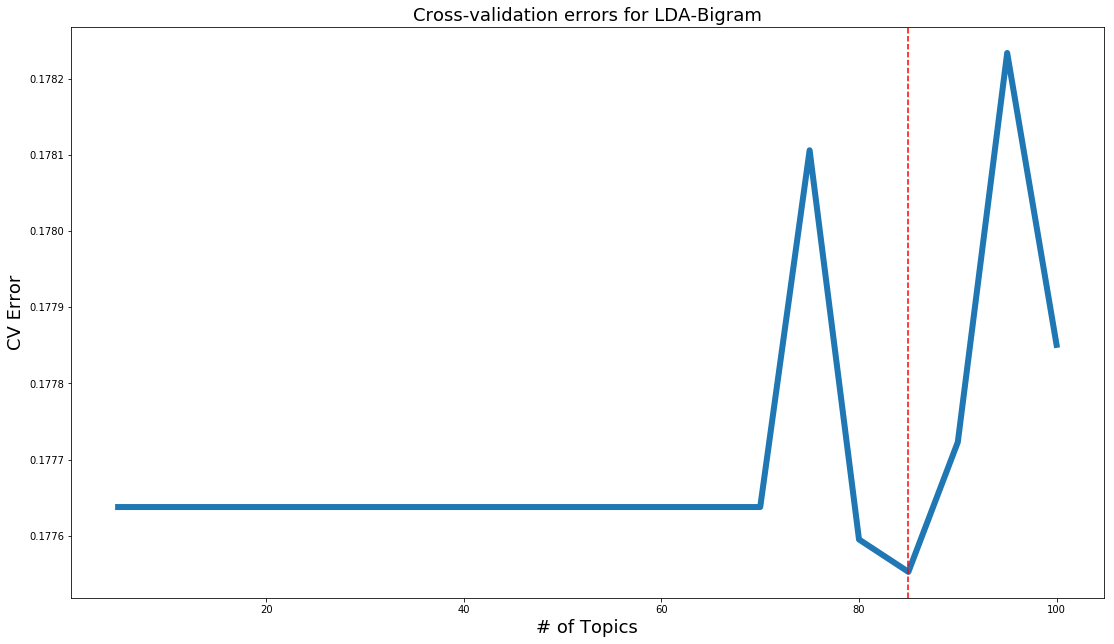

In [60]:
print('Cross-Validation...')
t1 = time.time()
n_topics = np.linspace(5,100,20).astype(int)
[best_topic_bi, best_lda_bi, cv_errors_bi] = ldaCV(texts_bigram, sentiment, n_topics)
print('Time used: %s seconds' % (time.time()-t1))
# Save model to disk
best_lda.save(os.path.join(path_save_data,'best_lda_bigram'))

# Svae figure
plt.figure()
plt.plot(n_topics, cv_errors_bi, linewidth = 6)
plt.axvline(x = best_topic_bi, color = 'r', linestyle = '--')
plt.xlabel('# of Topics', fontsize = 18)
plt.ylabel('CV Error', fontsize = 18)
plt.title('Cross-validation errors for LDA-Bigram', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5,10.5,5)
plt.show()
fig.savefig(os.path.join(path_save_fig, 'cv_errors_bigram.png'))

In [77]:
#######################
# Build the trigram models
t1 = time.time()
trigram = models.Phrases(bigram[texts], threshold=1) 
# Faster way to get a sentence clubbed as a trigram/bigram
trigram_mod = models.phrases.Phraser(trigram) 
print('Time used: %s seconds' % (time.time()-t1))
# See example
print(trigram_mod[bigram_mod[texts[9]]])
texts_trigram = trigram_mod[bigram_mod[texts]]

2018-12-01 17:08:33,082 : INFO : collecting all words and their counts
2018-12-01 17:08:33,083 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-12-01 17:08:35,144 : INFO : PROGRESS: at sentence #10000, processed 205451 words and 189877 word types
2018-12-01 17:08:37,507 : INFO : PROGRESS: at sentence #20000, processed 414349 words and 342633 word types
2018-12-01 17:08:38,170 : INFO : collected 391375 word types from a corpus of 486316 words (unigram + bigrams) and 23486 sentences
2018-12-01 17:08:38,171 : INFO : using 391375 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
2018-12-01 17:08:38,172 : INFO : source_vocab length 391375
2018-12-01 17:08:47,210 : INFO : Phraser built with 10128 10128 phrasegrams


Time used: 14.13040804862976 seconds
["'m_5_''", '5_125', 'lb_order', 'petit', 'make_sure', "length_n't", 'long', 'typic_wear', 'xs_regular', 'retail_dress', "'re_less", 'busti', '34b_cup', 'smaller', 'petit_fit', 'perfectli_snug', 'tight', 'love', 'could_dress', 'parti_work', 'love', 'tull', 'longer', 'fabric', 'underneath']


In [78]:
# =============================================================================
#
print('Cross-Validation...')
t1 = time.time()
n_topics = np.linspace(5,100,20).astype(int)
[best_topic_tri, best_lda_tri, cv_errors_tri] = ldaCV(texts_trigram, sentiment, n_topics)
print('Time used: %s seconds' % (time.time()-t1))

2018-12-01 17:08:51,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


Cross-Validation...


2018-12-01 17:08:53,434 : INFO : adding document #10000 to Dictionary(28617 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...)
2018-12-01 17:08:55,942 : INFO : adding document #20000 to Dictionary(36007 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...)
2018-12-01 17:08:56,700 : INFO : built Dictionary(37096 unique tokens: ['absolut_wonder', 'comfort', 'sexi', 'silki', "'m_glad"]...) from 23486 documents (total 453049 corpus positions)
2018-12-01 17:09:01,324 : INFO : collecting document frequencies
2018-12-01 17:09:01,325 : INFO : PROGRESS: processing document #0
2018-12-01 17:09:01,367 : INFO : PROGRESS: processing document #10000
2018-12-01 17:09:01,406 : INFO : PROGRESS: processing document #20000
2018-12-01 17:09:01,434 : INFO : calculating IDF weights for 23486 documents and 6888 features (229035 matrix non-zeros)
2018-12-01 17:09:01,475 : INFO : using symmetric alpha at 0.2
2018-12-01 17:09:01,477 : INFO : using symmetric eta a

2018-12-01 17:09:09,014 : INFO : PROGRESS: pass 0, at document #12000/23486
2018-12-01 17:09:10,149 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:09:10,183 : INFO : topic #0 (0.200): 0.006*"knee" + 0.006*"love_jumpsuit" + 0.005*"cardigan" + 0.005*"one" + 0.005*"dress" + 0.004*"pretti" + 0.004*"outrag" + 0.004*"fabric_thick" + 0.004*"also" + 0.004*"line"
2018-12-01 17:09:10,185 : INFO : topic #1 (0.200): 0.011*"knee" + 0.006*"cardigan" + 0.006*"perfect" + 0.005*"pretti" + 0.005*"outrag" + 0.005*"bc" + 0.005*"frame" + 0.004*"5'9_height" + 0.004*"alway" + 0.004*"hte_xs"
2018-12-01 17:09:10,188 : INFO : topic #2 (0.200): 0.007*"cardigan" + 0.006*"pretti" + 0.005*"knee" + 0.004*"charcoal" + 0.004*"comfort" + 0.003*"alway" + 0.003*"bc" + 0.003*"outrag" + 0.003*"frame" + 0.003*"love_jumpsuit"
2018-12-01 17:09:10,201 : INFO : topic #3 (0.200): 0.008*"knee" + 0.006*"cardigan" + 0.006*"long" + 0.005*"pretti" + 0.005*"one" + 0.004*"usual_wear" + 0.004*

2018-12-01 17:09:19,556 : INFO : topic diff=0.085596, rho=0.301511
2018-12-01 17:09:20,441 : INFO : -9.249 per-word bound, 608.5 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:09:20,442 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:09:21,098 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:09:21,126 : INFO : topic #0 (0.200): 0.004*"fabric_thick" + 0.003*"pretti" + 0.003*"dress" + 0.003*"black" + 0.003*"knee" + 0.003*"cardigan" + 0.003*"line" + 0.003*"return_one" + 0.002*"practic" + 0.002*"tri_4"
2018-12-01 17:09:21,128 : INFO : topic #1 (0.200): 0.011*"knee" + 0.008*"cardigan" + 0.007*"pretti" + 0.006*"outrag" + 0.005*"skirt_flare" + 0.005*"bc" + 0.005*"love_jumpsuit" + 0.005*"5'9_height" + 0.005*"alway" + 0.005*"also"
2018-12-01 17:09:21,130 : INFO : topic #2 (0.200): 0.004*"cardigan" + 0.003*"floor" + 0.003*"pretti" + 0.003*"charcoal" + 0.002*"find_anyth" + 0.002*"comfort" +

Number of topics: 5 ; Cross validation error: 0.17763777


2018-12-01 17:09:37,383 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:09:38,194 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:09:38,258 : INFO : topic #8 (0.100): 0.006*"line" + 0.006*"cardigan" + 0.006*"knee" + 0.005*"frame" + 0.004*"pretti" + 0.004*"outrag" + 0.004*"alway" + 0.004*"bottom_half" + 0.004*"fix" + 0.003*"front_pleat"
2018-12-01 17:09:38,262 : INFO : topic #5 (0.100): 0.007*"embroid_print" + 0.006*"5'9_height" + 0.006*"pretti" + 0.006*"outrag" + 0.005*"cardigan" + 0.005*"knee" + 0.004*"usual_wear" + 0.004*"5'8_''" + 0.004*"bc" + 0.004*"dress"
2018-12-01 17:09:38,265 : INFO : topic #7 (0.100): 0.009*"pant" + 0.007*"cardigan" + 0.007*"charcoal" + 0.006*"knee" + 0.005*"one" + 0.005*"narrow_skirt" + 0.004*"frame" + 0.004*"long" + 0.004*"love_jumpsuit" + 0.004*"usual_wear"
2018-12-01 17:09:38,267 : INFO : topic #1 (0.100): 0.008*"usual_wear" + 0.007*"knee" + 0.006*"alway" + 0.006*"cardigan" + 0.005*"usual_retail" 

2018-12-01 17:09:42,703 : INFO : topic diff=0.109540, rho=0.408248
2018-12-01 17:09:42,911 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:09:43,501 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:09:43,558 : INFO : topic #7 (0.100): 0.004*"knee" + 0.004*"'m_upset" + 0.004*"'m_5'4" + 0.004*"also_found" + 0.004*"happen_find" + 0.003*"pant" + 0.003*"velvet" + 0.003*"charcoal" + 0.003*"'s_warm" + 0.003*"end_knee"
2018-12-01 17:09:43,561 : INFO : topic #6 (0.100): 0.007*"flirti_feminin" + 0.005*"zipper" + 0.004*"135_pound" + 0.004*"5'1.5_''_115_lb" + 0.004*"rest_fit" + 0.004*"135" + 0.003*"make_sure" + 0.003*"'m_5'7_''_140" + 0.003*"tie_close" + 0.003*"intim"
2018-12-01 17:09:43,563 : INFO : topic #8 (0.100): 0.005*"shirt_flatter" + 0.005*"cardigan" + 0.005*"fix" + 0.004*"knee" + 0.004*"pretti" + 0.004*"frame" + 0.003*"line" + 0.003*"'m_glad" + 0.003*"return_one" + 0.003*"petit_decid"
2018-12-01 17:09:43,566 : INFO : topic #4 (0.

2018-12-01 17:09:48,305 : INFO : topic #1 (0.100): 0.013*"knee" + 0.010*"cardigan" + 0.009*"pretti" + 0.008*"outrag" + 0.007*"love_jumpsuit" + 0.007*"usual_wear" + 0.007*"alway" + 0.007*"skirt_flare" + 0.007*"also" + 0.006*"bc"
2018-12-01 17:09:48,308 : INFO : topic #3 (0.100): 0.005*"nice_weight" + 0.005*"white" + 0.004*"go-to_top" + 0.004*"estim" + 0.004*"difficult_zip" + 0.003*"25_waist" + 0.003*"'ve_look" + 0.003*"'m_xl" + 0.003*"feel_like" + 0.003*"opinion_tie"
2018-12-01 17:09:48,310 : INFO : topic #2 (0.100): 0.004*"time" + 0.004*"transit_easili" + 0.004*"strang_fit" + 0.004*"comfort" + 0.004*"'s_slight" + 0.004*"stylist" + 0.004*"look" + 0.003*"ca_n't_see" + 0.003*"curvier" + 0.003*"away_wear"
2018-12-01 17:09:48,313 : INFO : topic diff=0.058528, rho=0.288675
2018-12-01 17:10:00,918 : INFO : using symmetric alpha at 0.06666666666666667
2018-12-01 17:10:00,919 : INFO : using symmetric eta at 0.06666666666666667
2018-12-01 17:10:00,929 : INFO : using serial LDA version on this no

Number of topics: 10 ; Cross validation error: 0.17763777


2018-12-01 17:10:01,168 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:10:01,756 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:10:01,835 : INFO : topic #0 (0.067): 0.009*"pretti" + 0.006*"bc" + 0.006*"adjust" + 0.005*"knee" + 0.005*"one" + 0.005*"also" + 0.005*"pant" + 0.004*"dress" + 0.004*"5'9_height" + 0.004*"qualiti"
2018-12-01 17:10:01,837 : INFO : topic #1 (0.067): 0.009*"pretti" + 0.009*"cardigan" + 0.007*"bc" + 0.005*"knee" + 0.005*"outrag" + 0.005*"oop" + 0.004*"adjust" + 0.004*"usual_wear" + 0.004*"frame" + 0.004*"front_pleat"
2018-12-01 17:10:01,840 : INFO : topic #11 (0.067): 0.010*"usual_wear" + 0.006*"cardigan" + 0.006*"love_jumpsuit" + 0.005*"pretti" + 0.005*"love_shirt" + 0.005*"also" + 0.004*"frame" + 0.004*"unsnap" + 0.004*"outrag" + 0.004*"one"
2018-12-01 17:10:01,842 : INFO : topic #13 (0.067): 0.007*"usual_wear" + 0.006*"comfort" + 0.006*"knee" + 0.005*"alway" + 0.005*"cardigan" + 0.004*"outrag" + 0.004

2018-12-01 17:10:06,079 : INFO : topic diff=0.094610, rho=0.408248
2018-12-01 17:10:06,240 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:10:06,786 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:10:06,863 : INFO : topic #0 (0.067): 0.009*"narrow_skirt" + 0.008*"pretti" + 0.006*"knee" + 0.005*"jean_skirt" + 0.005*"cardigan" + 0.004*"style_uniqu" + 0.004*"adjust" + 0.004*"raw_edg" + 0.004*"fit_ok" + 0.004*"figur_flatter"
2018-12-01 17:10:06,865 : INFO : topic #4 (0.067): 0.007*"'m_glad" + 0.006*"color_great" + 0.006*"mainli" + 0.006*"beauti_color" + 0.005*"still_great" + 0.005*"cut" + 0.005*"pull" + 0.005*"knee" + 0.005*"made_china" + 0.004*"front_gap"
2018-12-01 17:10:06,867 : INFO : topic #3 (0.067): 0.007*"long" + 0.006*"zip" + 0.005*"want_someth" + 0.005*"bough" + 0.005*"top" + 0.005*"one_side" + 0.005*"knee" + 0.004*"atleast" + 0.004*"dress_look" + 0.004*"gorgeou_turn"
2018-12-01 17:10:06,870 : INFO : topic #2 (0.067): 0

2018-12-01 17:10:12,038 : INFO : topic #12 (0.067): 0.009*"tee" + 0.008*"med_fit" + 0.006*"dont_think" + 0.005*"receiv_lot_compliment" + 0.005*"reciev" + 0.004*"insul" + 0.004*"fo" + 0.004*"size_sinc" + 0.004*"bit_flair" + 0.004*"tank_top"
2018-12-01 17:10:12,040 : INFO : topic #6 (0.067): 0.008*"color_vibrant" + 0.007*"return_one" + 0.007*"movement_skirt" + 0.006*"5'6_''" + 0.005*"usual_wear_size_4" + 0.005*"averag" + 0.005*"parti_work" + 0.005*"metal" + 0.005*"itchi" + 0.004*"grab"
2018-12-01 17:10:12,043 : INFO : topic #7 (0.067): 0.006*"well_construct" + 0.005*"25_waist" + 0.005*"me-" + 0.005*"'s_slight" + 0.005*"regular" + 0.004*"happen_see" + 0.004*"wear_medium" + 0.003*"n't_look_great" + 0.003*"piec" + 0.003*"holiday_gather"
2018-12-01 17:10:12,048 : INFO : topic diff=0.060847, rho=0.288675
2018-12-01 17:10:26,798 : INFO : using symmetric alpha at 0.05
2018-12-01 17:10:26,800 : INFO : using symmetric eta at 0.05
2018-12-01 17:10:26,820 : INFO : using serial LDA version on this n

Number of topics: 15 ; Cross validation error: 0.17763777


2018-12-01 17:10:27,229 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:10:27,914 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:10:28,049 : INFO : topic #15 (0.050): 0.010*"pant" + 0.009*"cardigan" + 0.007*"knee" + 0.006*"order_onlin" + 0.005*"hte_xs" + 0.004*"usual_wear" + 0.004*"embroid_print" + 0.004*"alway" + 0.004*"charcoal" + 0.004*"found"
2018-12-01 17:10:28,051 : INFO : topic #2 (0.050): 0.009*"frame" + 0.008*"oop" + 0.008*"love_jumpsuit" + 0.007*"gorgeou_turn" + 0.007*"cardigan" + 0.007*"usual_wear" + 0.005*"knee" + 0.005*"outrag" + 0.005*"long" + 0.005*"pretti"
2018-12-01 17:10:28,054 : INFO : topic #17 (0.050): 0.009*"cardigan" + 0.008*"alway" + 0.006*"pretti" + 0.006*"love_shirt" + 0.005*"charcoal" + 0.005*"love_jumpsuit" + 0.005*"knee" + 0.005*"petit_5" + 0.005*"usual_wear" + 0.005*"pant"
2018-12-01 17:10:28,057 : INFO : topic #18 (0.050): 0.010*"knee" + 0.005*"alway" + 0.005*"pretti" + 0.005*"outrag" + 0.005*"b

2018-12-01 17:10:34,689 : INFO : topic #9 (0.050): 0.007*"wear" + 0.006*"pretti" + 0.006*"wear_leg" + 0.005*"sit_high" + 0.005*"sweater" + 0.005*"fall_low" + 0.005*"snap" + 0.005*"color_soft_fabric" + 0.004*"exchang" + 0.004*"looser"
2018-12-01 17:10:34,693 : INFO : topic diff=0.095266, rho=0.408248
2018-12-01 17:10:35,026 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:10:36,030 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:10:36,193 : INFO : topic #12 (0.050): 0.010*"white" + 0.010*"comfort" + 0.009*"''" + 0.008*"knee" + 0.008*"front_pleat" + 0.006*"one" + 0.006*"cardigan" + 0.006*"shirt_flatter" + 0.006*"alway" + 0.006*"..."
2018-12-01 17:10:36,196 : INFO : topic #11 (0.050): 0.009*"5'9_height" + 0.008*"knee" + 0.007*"lot" + 0.007*"bust_waist" + 0.007*"skirt_flare" + 0.006*"ordinari" + 0.006*"ad_bonu" + 0.005*"unfortun_n't" + 0.005*"proport" + 0.005*"cardigan"
2018-12-01 17:10:36,201 : INFO : topic #17 (0.050): 0.013*"pr

2018-12-01 17:10:44,653 : INFO : topic #5 (0.050): 0.006*"knee" + 0.005*"give_support" + 0.005*"perfect_length" + 0.005*"cardigan" + 0.005*"felt_like" + 0.005*"pretti" + 0.005*"shopper" + 0.004*"also" + 0.004*"flaw" + 0.004*"like_other"
2018-12-01 17:10:44,656 : INFO : topic #7 (0.050): 0.013*"ca_n't_wait_wear" + 0.012*"return_one" + 0.008*"kept" + 0.007*"wish_list" + 0.006*"believ" + 0.005*"bc_'s" + 0.005*"5'8_140lb" + 0.005*"ca_n't_see" + 0.005*"drape" + 0.005*"super_cozi"
2018-12-01 17:10:44,658 : INFO : topic #10 (0.050): 0.009*"garment" + 0.007*"qualiti_definit" + 0.007*"v_necklin" + 0.006*"one" + 0.006*"well_endow" + 0.006*"petit_weigh" + 0.005*"adjust" + 0.005*"pretti" + 0.005*"teh_color" + 0.005*"sheer_light"
2018-12-01 17:10:44,663 : INFO : topic diff=0.053997, rho=0.288675
2018-12-01 17:11:02,185 : INFO : using symmetric alpha at 0.04
2018-12-01 17:11:02,187 : INFO : using symmetric eta at 0.04
2018-12-01 17:11:02,208 : INFO : using serial LDA version on this node


Number of topics: 20 ; Cross validation error: 0.17763777


2018-12-01 17:11:02,412 : INFO : running online (single-pass) LDA training, 25 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:11:02,715 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:11:03,630 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:11:03,794 : INFO : topic #0 (0.040): 0.007*"charcoal" + 0.007*"love_shirt" + 0.007*"love_jumpsuit" + 0.006*"hte_xs" + 0.005*"narrow_skirt" + 0.005*"long" + 0.005*"usual_wear" + 0.005*"pant" + 0.005*"petit_decid" + 0.005*"zipper"
2018-12-01 17:11:03,797 : INFO : topic #7 (0.040): 0.008*"pretti" + 0.007*"long" + 0.006*"cardigan" + 0.006*"want_fit" + 0.006*"also" + 0.005*"outrag" + 0.005*"knee" + 0.005*"petit_small" + 0.004*"one" + 0.004*"alway"
2018-12-01 17:11:03,799 : INFO : topic #4 (0.040): 0.007*"pant" + 0.006*"knee" +

2018-12-01 17:11:10,082 : INFO : topic #15 (0.040): 0.012*"'m_glad" + 0.009*"bought_top" + 0.009*"casual_yet" + 0.008*"length_fine" + 0.007*"stylist" + 0.007*"need_dri" + 0.007*"'m_rather" + 0.007*"beauti_color" + 0.006*"redo" + 0.006*"silki"
2018-12-01 17:11:10,087 : INFO : topic diff=0.085265, rho=0.408248
2018-12-01 17:11:10,283 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:11:11,112 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:11:11,245 : INFO : topic #0 (0.040): 0.014*"usual_wear" + 0.010*"charcoal" + 0.010*"make_sure" + 0.009*"gap_front" + 0.007*"zipper" + 0.006*"absolut_wonder" + 0.006*"cardigan" + 0.006*"love_everyth" + 0.006*"hte_xs" + 0.006*"ad_bonu"
2018-12-01 17:11:11,247 : INFO : topic #4 (0.040): 0.014*"embroid_print" + 0.013*"dress_pretti" + 0.010*"dear_retail" + 0.010*"ca_n't_wait_wear" + 0.007*"spring" + 0.006*"knee" + 0.006*"reciev" + 0.006*"qualiti_definit" + 0.006*"bib_tee" + 0.006*"'m_upset"
2018-12-

2018-12-01 17:11:19,574 : INFO : topic #19 (0.040): 0.022*"find_anyth" + 0.011*"fit_great" + 0.010*"flaw" + 0.009*"wear_leg" + 0.008*"definit_go_back" + 0.007*"opinion_tie" + 0.007*"realli" + 0.007*"belli" + 0.006*"5'8_140lb" + 0.006*"shoulder_tight"
2018-12-01 17:11:19,578 : INFO : topic #18 (0.040): 0.015*"5'3_''" + 0.012*"return_one" + 0.009*"least" + 0.008*"'s_simpl" + 0.008*"navi_blazer" + 0.008*"leg_open" + 0.007*"necklin_slightli" + 0.007*"inch" + 0.007*"n't_need" + 0.006*"neat"
2018-12-01 17:11:19,582 : INFO : topic #24 (0.040): 0.023*"pretti" + 0.011*"excit_arriv" + 0.010*"long" + 0.009*"super" + 0.009*"torso" + 0.008*"tri_store" + 0.008*"sweep" + 0.008*"spring_summer" + 0.008*"price" + 0.007*"'s_thin"
2018-12-01 17:11:19,586 : INFO : topic #17 (0.040): 0.019*"black" + 0.014*"gorgeou_top" + 0.011*"quirki" + 0.010*"ton_stuff" + 0.009*"cape" + 0.009*"petit_weigh" + 0.008*"shoulder_necklin" + 0.007*"dont_think" + 0.007*"oop" + 0.007*"wear_time"
2018-12-01 17:11:19,592 : INFO : to

Number of topics: 25 ; Cross validation error: 0.17763777


2018-12-01 17:11:36,592 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:11:37,149 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:11:37,302 : INFO : topic #21 (0.033): 0.012*"pant" + 0.008*"love_jumpsuit" + 0.007*"also" + 0.007*"embroid_print" + 0.007*"cardigan" + 0.007*"skirt_flare" + 0.007*"knee" + 0.007*"happen_find" + 0.006*"long" + 0.006*"order_onlin"
2018-12-01 17:11:37,304 : INFO : topic #13 (0.033): 0.009*"dress" + 0.008*"love_jumpsuit" + 0.008*"knee" + 0.007*"frame" + 0.006*"slip" + 0.006*"qualiti" + 0.006*"bc" + 0.005*"'s_sooo" + 0.005*"adjust" + 0.005*"2_''"
2018-12-01 17:11:37,306 : INFO : topic #4 (0.033): 0.007*"outrag" + 0.006*"knee" + 0.006*"usual_wear" + 0.006*"embroid_print" + 0.006*"c" + 0.005*"crisp_clean" + 0.005*"5'9_height" + 0.005*"perfectli_snug" + 0.005*"length" + 0.005*"alway"
2018-12-01 17:11:37,309 : INFO : topic #17 (0.033): 0.007*"knee" + 0.007*"narrow_skirt" + 0.007*"5'9_height" + 0.006*"pant" +

2018-12-01 17:11:41,846 : INFO : topic #16 (0.033): 0.012*"..." + 0.010*"summer" + 0.010*"say" + 0.009*"redeem_qualiti" + 0.008*"got_stuck" + 0.007*"huge" + 0.007*"first" + 0.007*"peplum" + 0.006*"lower_cut" + 0.006*"guess"
2018-12-01 17:11:41,851 : INFO : topic diff=0.084259, rho=0.408248
2018-12-01 17:11:42,009 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:11:42,544 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:11:42,697 : INFO : topic #25 (0.033): 0.016*"fabric_thick" + 0.011*"one" + 0.010*"knee" + 0.010*"34b_cup" + 0.009*"fit_tight" + 0.008*"camisol" + 0.008*"bottom_half" + 0.007*"'m_upset" + 0.007*"outrag" + 0.007*"love"
2018-12-01 17:11:42,699 : INFO : topic #13 (0.033): 0.011*"frame" + 0.010*"knee" + 0.009*"comment_``" + 0.008*"better_fit" + 0.008*"ordinari" + 0.007*"provid_support" + 0.007*"snug_bust" + 0.007*"littl_big" + 0.007*"keyhol_back" + 0.006*"size_accur"
2018-12-01 17:11:42,701 : INFO : topic #14 (0.033):

2018-12-01 17:11:48,549 : INFO : topic #16 (0.033): 0.013*"say" + 0.012*"photograph_model" + 0.012*"..." + 0.012*"summer" + 0.009*"got_stuck" + 0.008*"surprisingli_flatter" + 0.008*"order_size_4" + 0.008*"guess" + 0.008*"first" + 0.008*"includ"
2018-12-01 17:11:48,551 : INFO : topic #0 (0.033): 0.013*"felt" + 0.012*"front_pleat" + 0.012*"n't_hesit_buy" + 0.011*"v_necklin" + 0.010*"tri_4" + 0.010*"area" + 0.008*"fabric_pretti" + 0.007*"go_larger" + 0.007*"chubbi" + 0.007*"knee"
2018-12-01 17:11:48,554 : INFO : topic #28 (0.033): 0.020*"shirt_flatter" + 0.012*"belli" + 0.011*"next" + 0.011*"make_perfect" + 0.010*"averag" + 0.010*"wedg" + 0.010*"also_found" + 0.010*"snug_bust" + 0.009*"smaller" + 0.009*"dress_extrem"
2018-12-01 17:11:48,557 : INFO : topic #2 (0.033): 0.011*"black" + 0.011*"gray" + 0.010*"ldecid" + 0.009*"small_bust" + 0.009*"look_like" + 0.008*"knee" + 0.007*"size_0" + 0.007*"oop" + 0.007*"ago_final" + 0.007*"hte"
2018-12-01 17:11:48,563 : INFO : topic diff=0.049493, rho=

Number of topics: 30 ; Cross validation error: 0.17763777


2018-12-01 17:12:06,272 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:12:06,552 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:12:07,656 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:12:07,916 : INFO : topic #28 (0.029): 0.009*"alway" + 0.009*"pretti" + 0.007*"usual_wear" + 0.007*"also" + 0.006*"one" + 0.005*"long" + 0.005*"skirt_flare" + 0.005*"sinc" + 0.004*"'s_sooo" + 0.004*"cedar"
2018-12-01 17:12:07,919 : INFO : topic #33 (0.029): 0.010*"cardigan" + 0.007*"terribl" + 0.007*"knee" + 0.006*"charcoal" + 0.006*"stat" + 0.006*"skirt_flare" + 0.005*"color_realli_nice" + 0.005*"frame" + 0.005*"hand-knit" + 0.005*"look_feel_cheap"
2018-12-01 17:12:07,922 : INFO : topic #15 (0.029): 0.008*"area" + 0.008*"

2018-12-01 17:12:13,552 : INFO : topic #20 (0.029): 0.013*"alway" + 0.011*"knee" + 0.011*"cardigan" + 0.009*"blue_color" + 0.008*"6_small" + 0.008*"cowl" + 0.007*"pretti" + 0.007*"though" + 0.007*"find_someth" + 0.007*"n't_decid"
2018-12-01 17:12:13,554 : INFO : topic #26 (0.029): 0.020*"averag" + 0.018*"smaller" + 0.016*"wear" + 0.012*"top" + 0.011*"tigh" + 0.011*"much" + 0.009*"overal" + 0.008*"got_lot_compliment" + 0.007*"length" + 0.007*"dress_extrem"
2018-12-01 17:12:13,565 : INFO : topic diff=0.088510, rho=0.408248
2018-12-01 17:12:13,735 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:12:14,316 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:12:14,499 : INFO : topic #19 (0.029): 0.017*"fit_great" + 0.010*"ankl" + 0.009*"tank_top" + 0.009*"casual_yet" + 0.009*"gorgeou" + 0.008*"go_larger" + 0.008*"opinion" + 0.008*"even_size" + 0.008*"one_side" + 0.008*"sit_high"
2018-12-01 17:12:14,501 : INFO : topic #33 (0.029): 0.020

2018-12-01 17:12:20,265 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:12:20,642 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:12:20,821 : INFO : topic #12 (0.029): 0.020*"like" + 0.018*"5'3_''" + 0.014*"onlin" + 0.011*"'s_great" + 0.011*"keep" + 0.010*"style_uniqu" + 0.009*"smoothli" + 0.008*"onlin_pictur" + 0.007*"pair" + 0.007*"good_length"
2018-12-01 17:12:20,823 : INFO : topic #7 (0.029): 0.013*"'s_eve" + 0.013*"embroideri_love" + 0.012*"tad_bit" + 0.011*"'m_rather" + 0.010*"tag" + 0.009*"regular" + 0.009*"provid_support" + 0.009*"wore_busi" + 0.009*"show" + 0.008*"petit_would"
2018-12-01 17:12:20,825 : INFO : topic #10 (0.029): 0.010*"knee" + 0.008*"flaw" + 0.008*"great_top" + 0.007*"size_chart" + 0.007*"cardigan" + 0.007*"light_weight" + 0.006*"130" + 0.006*"wish_list" + 0.006*"order_larger_size" + 0.006*"camisol"
2018-12-01 17:12:20,827 : INFO : topic #6 (0.029): 0.016*"usual_wear_medium" + 0.015*"difficult_zip" + 

Number of topics: 35 ; Cross validation error: 0.17763777


2018-12-01 17:12:37,137 : INFO : running online (single-pass) LDA training, 40 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:12:37,289 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:12:37,838 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:12:38,045 : INFO : topic #20 (0.025): 0.012*"case" + 0.011*"petit_5" + 0.010*"usual_wear" + 0.008*"skirt_flare" + 0.008*"knee" + 0.007*"also" + 0.007*"petit_small" + 0.007*"n't" + 0.006*"smallest_size" + 0.006*"alway"
2018-12-01 17:12:38,046 : INFO : topic #33 (0.025): 0.008*"white" + 0.008*"knee" + 0.007*"perfectli_snug" + 0.007*"order" + 0.006*"fabul" + 0.006*"charcoal" + 0.005*"long" + 0.005*"would_definit" + 0.005*"back" + 0.005*"perfect"
2018-12-01 17:12:38,048 : INFO : topic #32 (0.025): 0.009*"qualiti_wonder" + 0.0

2018-12-01 17:12:43,571 : INFO : topic #16 (0.025): 0.020*"v_necklin" + 0.018*"like" + 0.015*"'m_upset" + 0.010*"narrow_skirt" + 0.010*"soft" + 0.009*"n't_decid" + 0.009*"skirt_flare" + 0.008*"l_sometim" + 0.008*"happen_find" + 0.007*"cardigan"
2018-12-01 17:12:43,574 : INFO : topic #22 (0.025): 0.017*"make_perfect" + 0.016*"3_month" + 0.013*"dress_pretti" + 0.010*"bought_petit" + 0.010*"size_sinc" + 0.009*"price" + 0.009*"xs_regular" + 0.008*"run_small" + 0.008*"cedar" + 0.008*"usual_prefer"
2018-12-01 17:12:43,577 : INFO : topic #3 (0.025): 0.013*"back_hang" + 0.012*"stat" + 0.009*"tad_bit" + 0.009*"love_jumpsuit" + 0.008*"still_worth" + 0.008*"knee" + 0.008*"care" + 0.007*"went" + 0.007*"definit_size" + 0.007*"'m_5'4"
2018-12-01 17:12:43,586 : INFO : topic diff=0.085446, rho=0.408248
2018-12-01 17:12:43,832 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:12:44,506 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:12:44,724 :

2018-12-01 17:12:49,666 : INFO : topic diff=0.057520, rho=0.301511
2018-12-01 17:12:50,737 : INFO : -12.248 per-word bound, 4864.1 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:12:50,738 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:12:51,139 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:12:51,347 : INFO : topic #2 (0.025): 0.018*"love_design" + 0.015*"stun" + 0.013*"order" + 0.012*"definit_go_back" + 0.012*"basket" + 0.012*"'m_rather" + 0.012*"small_bust" + 0.010*"'m_go_keep" + 0.010*"petit_would" + 0.009*"better_fit"
2018-12-01 17:12:51,349 : INFO : topic #23 (0.025): 0.015*"sleev_wide" + 0.015*"garment" + 0.013*"dear_retail" + 0.012*"hand-knit" + 0.011*"fit_great" + 0.011*"length" + 0.011*"embellish" + 0.011*"look_great" + 0.010*"adjust" + 0.010*"smaller"
2018-12-01 17:12:51,351 : INFO : topic #11 (0.025): 0.022*"qualiti_definit" + 0.021*"tee" + 0.017*"ago_final" + 0.013

Number of topics: 40 ; Cross validation error: 0.17763777


2018-12-01 17:13:07,134 : INFO : running online (single-pass) LDA training, 45 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:13:07,287 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:13:07,826 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:13:08,067 : INFO : topic #41 (0.022): 0.006*"packag" + 0.005*"blous" + 0.005*"knee" + 0.005*"5'9_height" + 0.005*"extraordinari" + 0.005*"smallest_size" + 0.005*"tent" + 0.005*"high_rise" + 0.005*"much_pronounc" + 0.005*"also"
2018-12-01 17:13:08,069 : INFO : topic #29 (0.022): 0.011*"5'9_height" + 0.007*"cardigan" + 0.006*"fabric_thick" + 0.006*"week" + 0.005*"mani" + 0.005*"color_blond" + 0.005*"skirt_flare" + 0.005*"snug_fit" + 0.005*"live_hot" + 0.004*"top"
2018-12-01 17:13:08,071 : INFO : topic #33 (0.022): 0.010*"pr

2018-12-01 17:13:13,781 : INFO : topic #18 (0.022): 0.022*"tee" + 0.020*"dear_retail" + 0.019*"shoulder_necklin" + 0.018*"reorder_petit" + 0.015*"fabric_pretti" + 0.011*"petit_weigh" + 0.010*"'s_eve" + 0.010*"salesperson" + 0.009*"adjust" + 0.009*"metal"
2018-12-01 17:13:13,783 : INFO : topic #34 (0.022): 0.018*"petit_decid" + 0.017*"zip" + 0.013*"floor" + 0.013*"'m_glad" + 0.010*"hte" + 0.010*"knee" + 0.010*"n't_sure" + 0.009*"'m_upset" + 0.009*"dress" + 0.009*"definit_go_back"
2018-12-01 17:13:13,791 : INFO : topic diff=0.090129, rho=0.408248
2018-12-01 17:13:14,822 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:13:15,387 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:13:15,667 : INFO : topic #36 (0.022): 0.018*"c" + 0.015*"color_nice" + 0.014*"5_''" + 0.013*"get_mani_compliment" + 0.012*"itali" + 0.012*"cardigan" + 0.011*"'m_rather" + 0.010*"tank_top" + 0.009*"fit_model" + 0.009*"week_ago"
2018-12-01 17:13:15,669 : INFO 

2018-12-01 17:13:23,523 : INFO : topic #14 (0.022): 0.027*"movement_skirt" + 0.022*"camisol" + 0.022*"needless_say" + 0.020*"altern" + 0.019*"shopper" + 0.019*"straight" + 0.018*"would" + 0.017*"embroid_print" + 0.014*"opinion" + 0.013*"sheer_fabric"
2018-12-01 17:13:23,525 : INFO : topic #2 (0.022): 0.020*"downsid" + 0.018*"lb_order" + 0.015*"warm" + 0.014*"net" + 0.012*"summer" + 0.012*"neat" + 0.012*"expect" + 0.011*"tailor" + 0.011*"wear_medium" + 0.010*"green_tone"
2018-12-01 17:13:23,527 : INFO : topic #28 (0.022): 0.014*"wedg" + 0.013*"difficult_zip" + 0.012*"far" + 0.011*"go_back" + 0.011*"design_color" + 0.010*"perfect_spot" + 0.009*"move" + 0.008*"didnt" + 0.008*"knee" + 0.008*"still_tight"
2018-12-01 17:13:23,530 : INFO : topic #1 (0.022): 0.015*"knee_conserv" + 0.014*"unfortun_n't" + 0.014*"shoulder_tight" + 0.012*"well_construct" + 0.012*"although" + 0.012*"get_lot_wear" + 0.011*"color_soft_fabric" + 0.010*"stuck" + 0.010*"130" + 0.010*"waterproof"
2018-12-01 17:13:23,532 

Number of topics: 45 ; Cross validation error: 0.17763777


2018-12-01 17:13:44,439 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:13:45,132 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:13:46,122 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:13:46,477 : INFO : topic #2 (0.020): 0.007*"knee" + 0.007*"3" + 0.007*"embroid_print" + 0.007*"one" + 0.006*"ship_week" + 0.005*"caus" + 0.005*"live_hot" + 0.005*"white" + 0.004*"rip" + 0.004*"stat"
2018-12-01 17:13:46,481 : INFO : topic #47 (0.020): 0.009*"outrag" + 0.009*"line" + 0.009*"cardigan" + 0.008*"usual_wear" + 0.008*"sinc" + 0.008*"dress_perfect" + 0.007*"''" + 0.007*"knee" + 0.007*"dress" + 0.007*"skirt_flare"
2018-12-01 17:13:46,484 : INFO : topic #7 (0.020): 0.008*"look_feel_cheap" + 0.008*"usual_wear" + 0.0

2018-12-01 17:13:54,150 : INFO : topic #47 (0.020): 0.017*"give_support" + 0.014*"line" + 0.011*"knee" + 0.011*"shoulder_necklin" + 0.010*"dress_perfect" + 0.010*"nice_choic" + 0.010*"far" + 0.009*"wedg" + 0.009*"opinion_tie" + 0.009*"fabric_delic"
2018-12-01 17:13:54,155 : INFO : topic #39 (0.020): 0.014*"stranger" + 0.013*"price" + 0.011*"cute_top" + 0.010*"type_fabric" + 0.009*"pair_mani" + 0.008*"love_materi" + 0.008*"like_crop" + 0.008*"end_knee" + 0.007*"knee" + 0.007*"sinc"
2018-12-01 17:13:54,164 : INFO : topic diff=0.092424, rho=0.408248
2018-12-01 17:13:54,381 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:13:55,248 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:13:55,537 : INFO : topic #18 (0.020): 0.022*"v_necklin" + 0.017*"littl_long" + 0.016*"fit_true" + 0.015*"case" + 0.014*"length_fine" + 0.014*"difficult_zip" + 0.014*"camisol" + 0.013*"hope_make" + 0.013*"match" + 0.012*"way_small"
2018-12-01 17:13:55,539 :

2018-12-01 17:14:06,383 : INFO : topic #29 (0.020): 0.028*"nice_weight" + 0.021*"onlin" + 0.019*"unfortun_n't" + 0.018*"believ" + 0.017*"25_waist" + 0.016*"size_12" + 0.015*"atleast" + 0.015*"stuck" + 0.012*"lb_order" + 0.012*"onlin_pictur"
2018-12-01 17:14:06,385 : INFO : topic #43 (0.020): 0.022*"fabric_thick" + 0.015*"outrag" + 0.013*"5'3_''" + 0.013*"rock" + 0.012*"knee" + 0.012*"forth" + 0.011*"sweep" + 0.010*"pretti" + 0.010*"even_size" + 0.010*"fit_great"
2018-12-01 17:14:06,388 : INFO : topic #42 (0.020): 0.019*"went" + 0.018*"narrow_skirt" + 0.018*"beauti_color" + 0.017*"sexi" + 0.014*"form-fit_fall" + 0.013*"two_differ" + 0.013*"medium_fit_well" + 0.013*"tend_run" + 0.012*"usual_wear_size_4" + 0.009*"becam"
2018-12-01 17:14:06,391 : INFO : topic #7 (0.020): 0.023*"dress_pretti" + 0.018*"stun" + 0.017*"n't_end" + 0.014*"petit_weigh" + 0.014*"look_feel_cheap" + 0.013*"regular" + 0.010*"petit_might" + 0.010*"jewelri_belt" + 0.010*"rather" + 0.009*"navi_blazer"
2018-12-01 17:14:0

Number of topics: 50 ; Cross validation error: 0.17763777


2018-12-01 17:14:31,895 : INFO : running online (single-pass) LDA training, 55 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:14:32,230 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:14:33,078 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:14:33,397 : INFO : topic #12 (0.018): 0.008*"usual_wear" + 0.008*"cardigan" + 0.006*"pretti" + 0.006*"dress_perfect" + 0.006*"two_layer" + 0.006*"happi" + 0.006*"ad_bonu" + 0.006*"pant" + 0.006*"high_hope_dress" + 0.005*"care"
2018-12-01 17:14:33,400 : INFO : topic #28 (0.018): 0.009*"fell_flat" + 0.008*"littl" + 0.006*"pretti" + 0.006*"cardigan" + 0.006*"wore" + 0.006*"age-appropri" + 0.005*"given_second" + 0.005*"bottom_half" + 0.005*"skirt_flare" + 0.005*"never_know"
2018-12-01 17:14:33,402 : INFO : topic #42 (0.018): 

2018-12-01 17:14:40,952 : INFO : topic #17 (0.018): 0.012*"love" + 0.012*"lb_order" + 0.012*"could_zip" + 0.011*"color_great" + 0.011*"knee" + 0.010*"attach_shoulder" + 0.009*"stranger" + 0.009*"garment" + 0.009*"34b_cup" + 0.009*"jacket"
2018-12-01 17:14:40,954 : INFO : topic #37 (0.018): 0.047*"pretti" + 0.025*"chubbi" + 0.015*"wear_leg" + 0.015*"keyhol_back" + 0.014*"believ" + 0.012*"knee" + 0.012*"5'6_''" + 0.009*"two_differ" + 0.009*"brand_alway" + 0.009*"surprisingli_flatter"
2018-12-01 17:14:40,962 : INFO : topic diff=0.097796, rho=0.408248
2018-12-01 17:14:41,191 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:14:41,969 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:14:42,297 : INFO : topic #52 (0.018): 0.024*"clean" + 0.023*"smaller" + 0.020*"med_fit" + 0.018*"snug_bust" + 0.016*"shopper" + 0.015*"spring" + 0.015*"would_recommend" + 0.011*"'s_great" + 0.011*"true_size" + 0.010*"color_shown"
2018-12-01 17:14:42,301 :

2018-12-01 17:14:50,137 : INFO : topic #6 (0.018): 0.044*"gap_front" + 0.018*"5_''" + 0.017*"although" + 0.017*"zipper" + 0.015*"navi_blazer" + 0.014*"1_''" + 0.014*"littl_larg" + 0.012*"away_wear" + 0.011*"hope_make" + 0.010*"60_'s"
2018-12-01 17:14:50,139 : INFO : topic #15 (0.018): 0.028*"'m_rather" + 0.025*"love_love" + 0.019*"button" + 0.018*"interest" + 0.016*"transit_easili" + 0.016*"teh_color" + 0.016*"receiv_lot_compliment" + 0.015*"bib_tee" + 0.014*"mom" + 0.014*"usual_buy"
2018-12-01 17:14:50,142 : INFO : topic #5 (0.018): 0.033*"3" + 0.032*"n't_end" + 0.019*"sleeveless" + 0.014*"around_neck" + 0.013*"first" + 0.012*"made" + 0.012*"jean_pencil_skirt" + 0.011*"unless_want" + 0.011*"'m_sure" + 0.009*"larg"
2018-12-01 17:14:50,145 : INFO : topic #24 (0.018): 0.033*"movement_skirt" + 0.026*"sweep" + 0.022*"got_medium" + 0.022*"tigh" + 0.022*"nice_top" + 0.016*"want_love" + 0.014*"wash" + 0.012*"necklin_slightli" + 0.011*"could_tell" + 0.011*"realli_like"
2018-12-01 17:14:50,148 

Number of topics: 55 ; Cross validation error: 0.17763777


2018-12-01 17:15:11,355 : INFO : running online (single-pass) LDA training, 60 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:15:11,527 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:15:12,166 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:15:12,534 : INFO : topic #51 (0.017): 0.011*"frame" + 0.011*"dress_perfect" + 0.010*"alway" + 0.010*"cardigan" + 0.008*"color_vibrant" + 0.007*"tie_front" + 0.007*"perfect" + 0.007*"unsnap" + 0.006*"good_qualiti" + 0.006*"white"
2018-12-01 17:15:12,536 : INFO : topic #45 (0.017): 0.017*"usual_wear" + 0.010*"''" + 0.010*"basket" + 0.009*"love_shirt" + 0.007*"week" + 0.007*"sure_would" + 0.007*"lot_fabric" + 0.007*"petit_small" + 0.007*"usual_retail" + 0.006*"sinc"
2018-12-01 17:15:12,539 : INFO : topic #50 (0.017): 0.008*"

2018-12-01 17:15:18,242 : INFO : topic #47 (0.017): 0.024*"attach_shoulder" + 0.020*"135_pound" + 0.018*"keep_warm" + 0.016*"``_dark" + 0.016*"split" + 0.015*"winter_fall" + 0.012*"130lb" + 0.010*"turtleneck" + 0.009*"greenish" + 0.009*"sky_blue"
2018-12-01 17:15:18,245 : INFO : topic #37 (0.017): 0.034*"make_sure" + 0.025*"floor" + 0.021*"make_perfect" + 0.019*"embroideri_love" + 0.019*"tend_run" + 0.012*"bit_crop" + 0.012*"embroid_print" + 0.011*"would_look" + 0.010*"away_wear" + 0.009*"cape"
2018-12-01 17:15:18,253 : INFO : topic diff=0.096592, rho=0.408248
2018-12-01 17:15:18,409 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:15:18,908 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:15:19,210 : INFO : topic #55 (0.017): 0.015*"bought_petit" + 0.015*"get" + 0.014*"everyth" + 0.013*"overal" + 0.012*"sadli_return" + 0.012*"spring_summer" + 0.010*"wo_n't" + 0.010*"necklin_higher" + 0.009*"tight_across_chest" + 0.008*"gap"
20

2018-12-01 17:15:25,979 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:15:26,345 : INFO : topic #38 (0.017): 0.023*"quirki" + 0.018*"midi_dress" + 0.016*"pant" + 0.016*"wash" + 0.016*"ordinari" + 0.015*"ad_bonu" + 0.014*"easili" + 0.014*"would_stay" + 0.012*"qualiti" + 0.012*"crop_top"
2018-12-01 17:15:26,347 : INFO : topic #22 (0.017): 0.038*"tad_bit" + 0.031*"go_back" + 0.027*"go-to_top" + 0.020*"stranger" + 0.016*"though" + 0.014*"side_zipper" + 0.013*"wind" + 0.012*"summer_fall" + 0.010*"flat" + 0.009*"``_swing_''"
2018-12-01 17:15:26,350 : INFO : topic #1 (0.017): 0.040*"small_bust" + 0.032*"opaqu" + 0.022*"usual_wear_size_4" + 0.019*"review_written" + 0.018*"right_fit" + 0.017*"navi_blazer" + 0.015*"bib_tee" + 0.014*"see" + 0.013*"0p_brand" + 0.012*"end_knee"
2018-12-01 17:15:26,353 : INFO : topic #39 (0.017): 0.033*"clean" + 0.026*"crisp_clean" + 0.025*"ankl" + 0.020*"well_construct" + 0.018*"ship_week" + 0.014*"someth" + 0.013*"fall_l

Number of topics: 60 ; Cross validation error: 0.17763777


2018-12-01 17:15:52,025 : INFO : running online (single-pass) LDA training, 65 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:15:52,185 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:15:52,744 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:15:53,077 : INFO : topic #38 (0.015): 0.013*"area" + 0.008*"pretti" + 0.008*"comfort" + 0.007*"alway" + 0.007*"still_worth" + 0.006*"good_qualiti" + 0.006*"love_length" + 0.006*"c" + 0.006*"knee" + 0.006*"smoothli"
2018-12-01 17:15:53,080 : INFO : topic #21 (0.015): 0.014*"cardigan" + 0.012*"flatter_feminin" + 0.009*"happi" + 0.007*"cedar" + 0.006*"n't_sure" + 0.006*"3" + 0.006*"love_length" + 0.006*"net_layer" + 0.006*"5'9_height" + 0.006*"perfect"
2018-12-01 17:15:53,084 : INFO : topic #46 (0.015): 0.011*"pretti_flatter

2018-12-01 17:16:00,226 : INFO : topic #0 (0.015): 0.026*"fall" + 0.016*"style_uniqu" + 0.014*"order_xsp" + 0.013*"ladi" + 0.013*"parti_work" + 0.012*"peplum" + 0.012*"38_c" + 0.010*"recent_got" + 0.009*"statement_necklac" + 0.008*"definit_go_back"
2018-12-01 17:16:00,229 : INFO : topic #20 (0.015): 0.062*"ca_n't_wait_wear" + 0.027*"tend_run" + 0.026*"fit_great" + 0.025*"also_found" + 0.024*"narrow_skirt" + 0.023*"would_size" + 0.021*"shopper" + 0.014*"3_tag" + 0.013*"alreadi_sold" + 0.012*"fabric_beauti"
2018-12-01 17:16:00,235 : INFO : topic #24 (0.015): 0.027*"34a-28/29-36" + 0.021*"gorgeou" + 0.020*"dress_run_small" + 0.013*"middl" + 0.013*"winter_fall" + 0.012*"photo_measur" + 0.011*"intim" + 0.011*"fabric_stretch" + 0.010*"grab" + 0.009*"n't_itchi"
2018-12-01 17:16:00,247 : INFO : topic diff=0.098790, rho=0.408248
2018-12-01 17:16:00,621 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:16:01,564 : INFO : merging changes from 2000 documents into a model of 23486 d

2018-12-01 17:16:08,240 : INFO : topic diff=0.067465, rho=0.301511
2018-12-01 17:16:09,468 : INFO : -13.429 per-word bound, 11026.4 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:16:09,469 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:16:10,130 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:16:10,577 : INFO : topic #9 (0.015): 0.046*"find_anyth" + 0.026*"zipper" + 0.023*"jewelri_belt" + 0.019*"beauti" + 0.019*"definit_size" + 0.019*"flaw" + 0.017*"peek" + 0.014*"color_soft_fabric" + 0.013*"petit_might" + 0.013*"back"
2018-12-01 17:16:10,579 : INFO : topic #50 (0.015): 0.023*"embroid_print" + 0.022*"forth" + 0.022*"'s_warm" + 0.021*"color_vibrant" + 0.019*"basket" + 0.018*"far" + 0.017*"unfortun_return" + 0.016*"pair_funki" + 0.015*"knee" + 0.014*"pretti_disappoint"
2018-12-01 17:16:10,581 : INFO : topic #36 (0.015): 0.047*"movement_skirt" + 0.035*"embellish" + 0.027*"size_acc

Number of topics: 65 ; Cross validation error: 0.1779358


2018-12-01 17:16:36,743 : INFO : running online (single-pass) LDA training, 70 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:16:36,928 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:16:37,647 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:16:38,051 : INFO : topic #55 (0.014): 0.014*"away" + 0.011*"5'9_height" + 0.011*"kept_slip" + 0.008*"12" + 0.008*"tri_use" + 0.007*"might" + 0.007*"dress_perfect" + 0.007*"due" + 0.007*"long" + 0.007*"front_tie"
2018-12-01 17:16:38,053 : INFO : topic #68 (0.014): 0.011*"alway" + 0.010*"one" + 0.008*"34a-28/29-36" + 0.008*"torso" + 0.007*"cardigan" + 0.007*"beauti_shirt" + 0.007*"comfort" + 0.006*"big" + 0.006*"dress_perfect" + 0.006*"outrag"
2018-12-01 17:16:38,056 : INFO : topic #26 (0.014): 0.012*"knee" + 0.009*"perfect

2018-12-01 17:16:46,961 : INFO : topic #29 (0.014): 0.028*"could_tell" + 0.018*"n't_hesit_buy" + 0.015*"soft" + 0.015*"ordinari" + 0.014*"size_0" + 0.013*"run_big" + 0.012*"3_''" + 0.011*"hte" + 0.010*"middl" + 0.010*"super"
2018-12-01 17:16:46,965 : INFO : topic #26 (0.014): 0.057*"knee" + 0.050*"ca_n't_wait_wear" + 0.033*"white" + 0.016*"neat" + 0.015*"pretti" + 0.013*"'m_usual" + 0.012*"frame" + 0.012*"make_perfect" + 0.012*"cardigan" + 0.011*"alway"
2018-12-01 17:16:46,967 : INFO : topic #61 (0.014): 0.027*"ton_stuff" + 0.025*"sooooo" + 0.019*"even_size" + 0.018*"littl_high" + 0.017*"5'1.5_''_115_lb" + 0.012*"n't_look_great" + 0.010*"love_design" + 0.010*"reciev" + 0.009*"pictur_onlin" + 0.008*"ca_n't_go_wrong"
2018-12-01 17:16:46,977 : INFO : topic diff=0.103603, rho=0.408248
2018-12-01 17:16:47,266 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:16:48,616 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:16:49,398 : INFO 

2018-12-01 17:16:57,578 : INFO : -13.687 per-word bound, 13192.4 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:16:57,580 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:16:58,018 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:16:58,385 : INFO : topic #32 (0.014): 0.082*"love_color" + 0.038*"never_would" + 0.033*"love_look" + 0.031*"straight" + 0.028*"'m_go_keep" + 0.015*"jean_dressier" + 0.014*"1" + 0.013*"size_small" + 0.010*"post-babi" + 0.008*"fun_detail"
2018-12-01 17:16:58,387 : INFO : topic #46 (0.014): 0.030*"movement_skirt" + 0.027*"practic" + 0.027*"fall_roll" + 0.021*"l_sometim" + 0.013*"'s_slight" + 0.012*"leg_open" + 0.012*"lot_fabric" + 0.010*"collar_tie" + 0.010*"usual_retail" + 0.010*"knee"
2018-12-01 17:16:58,389 : INFO : topic #55 (0.014): 0.044*"like" + 0.029*"sort" + 0.022*"type_fabric" + 0.022*"proport" + 0.019*"materi_nice" + 0.019*"kept_slip" + 0.018*"5'9

Number of topics: 70 ; Cross validation error: 0.17763777


2018-12-01 17:17:19,511 : INFO : running online (single-pass) LDA training, 75 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:17:19,691 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:17:20,410 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:17:20,821 : INFO : topic #60 (0.013): 0.017*"cardigan" + 0.010*"downsid" + 0.009*"frame" + 0.008*"usual_wear" + 0.008*"keyhol_back" + 0.008*"easili" + 0.007*"realli_nice" + 0.006*"area" + 0.006*"36d_medium" + 0.006*"materi_structur"
2018-12-01 17:17:20,823 : INFO : topic #33 (0.013): 0.009*"pretti" + 0.008*"knee_conserv" + 0.007*"perfect" + 0.007*"want_fit" + 0.006*"heel" + 0.006*"embroid_print" + 0.006*"big" + 0.006*"broad_shoulder" + 0.006*"show_world" + 0.006*"xs_top"
2018-12-01 17:17:20,826 : INFO : topic #18 (0.013):

2018-12-01 17:17:27,498 : INFO : topic #27 (0.013): 0.018*"'s_littl" + 0.017*"receiv_numer_compliment" + 0.014*"fit_okay" + 0.013*"'s_uniqu" + 0.012*"slightli_less" + 0.012*"'s_sooo" + 0.009*"necklin_slightli" + 0.009*"unflatt" + 0.009*"n't_shrink" + 0.009*"skirt_justic"
2018-12-01 17:17:27,507 : INFO : topic #26 (0.013): 0.033*"waist" + 0.029*"better_fit" + 0.028*"go" + 0.025*"front_seam" + 0.022*"like_longer" + 0.019*"other_mention" + 0.013*"knee" + 0.013*"run_small" + 0.012*"zipper" + 0.012*"like_length"
2018-12-01 17:17:27,510 : INFO : topic #39 (0.013): 0.027*"top" + 0.025*"love" + 0.022*"feel_like" + 0.020*"opinion_run" + 0.014*"'s_call" + 0.013*"jean_dressier" + 0.009*"think_ask" + 0.009*"fell_right" + 0.008*"neutral_color" + 0.008*"light_sweater"
2018-12-01 17:17:27,522 : INFO : topic diff=0.082202, rho=0.408248
2018-12-01 17:17:27,857 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:17:28,814 : INFO : merging changes from 2000 documents into a model of 23486 d

2018-12-01 17:17:35,829 : INFO : topic diff=0.044667, rho=0.301511
2018-12-01 17:17:36,917 : INFO : -14.881 per-word bound, 30169.4 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:17:36,918 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:17:37,352 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:17:37,733 : INFO : topic #12 (0.013): 0.038*"love_length" + 0.037*"want_fit" + 0.030*"second" + 0.029*"lot" + 0.028*"me-" + 0.026*"anoth_neg" + 0.025*"3_tag" + 0.020*"spring_summer" + 0.019*"'s_simpl" + 0.016*"wear_flat"
2018-12-01 17:17:37,734 : INFO : topic #16 (0.013): 0.029*"ca_n't_wait_wear" + 0.023*"look_good" + 0.016*"retail_dress" + 0.015*"smoothli" + 0.015*"knee" + 0.014*"ca_n't_see" + 0.012*"unfortun_n't" + 0.012*"usual_wear_medium" + 0.012*"typic" + 0.012*"cardigan"
2018-12-01 17:17:37,737 : INFO : topic #32 (0.013): 0.100*"fabric_thick" + 0.046*"form-fit_fall" + 0.039*"tri" + 0

Number of topics: 75 ; Cross validation error: 0.17776547


2018-12-01 17:18:00,030 : INFO : running online (single-pass) LDA training, 80 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:18:00,313 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:18:01,377 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:18:02,431 : INFO : topic #65 (0.013): 0.011*"pant" + 0.009*"far" + 0.008*"one" + 0.008*"idea" + 0.008*"usual_wear" + 0.007*"order_carbon" + 0.007*"perfect" + 0.007*"pull_dress" + 0.007*"love_jumpsuit" + 0.007*"love_love"
2018-12-01 17:18:02,433 : INFO : topic #30 (0.013): 0.009*"5'9_height" + 0.008*"strang_fit" + 0.008*"opaqu" + 0.008*"realli_brighten" + 0.008*"make_lack" + 0.007*"print" + 0.007*"zipper" + 0.007*"heavi_denim" + 0.007*"narrow_skirt" + 0.006*"2_''"
2018-12-01 17:18:02,435 : INFO : topic #21 (0.013): 0.011*"

2018-12-01 17:18:12,776 : INFO : topic #2 (0.013): 0.051*"felt" + 0.023*"match" + 0.020*"color_nice" + 0.017*"etc" + 0.016*"opinion_run" + 0.013*"pant_trend" + 0.013*"happen_see" + 0.011*"6-8" + 0.010*"parti_work" + 0.010*"metal"
2018-12-01 17:18:12,779 : INFO : topic #30 (0.013): 0.026*"longer" + 0.016*"color_fade" + 0.016*"casual_wear" + 0.015*"littl_loos" + 0.014*"realli_brighten" + 0.014*"uniqu" + 0.014*"ankl" + 0.012*"38_c" + 0.011*"5'9_height" + 0.011*"strang_fit"
2018-12-01 17:18:12,790 : INFO : topic diff=0.039164, rho=0.408248
2018-12-01 17:18:13,025 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:18:13,970 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:18:14,893 : INFO : topic #38 (0.013): 0.053*"fabric_thick" + 0.034*"print" + 0.033*"'m_glad" + 0.024*"give_support" + 0.017*"recent_got" + 0.015*"34b_cup" + 0.015*"area" + 0.014*"knee" + 0.013*"cut" + 0.013*"5'9_height"
2018-12-01 17:18:14,895 : INFO : topic #25 (0.0

2018-12-01 17:18:26,248 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:18:27,189 : INFO : topic #56 (0.013): 0.051*"top_half" + 0.050*"would_n't" + 0.039*"waist" + 0.032*"even_size" + 0.030*"look_cute" + 0.029*"sleev_long" + 0.026*"love_shirt" + 0.024*"differ_top" + 0.021*"averag" + 0.021*"xs_regular"
2018-12-01 17:18:27,192 : INFO : topic #6 (0.013): 0.043*"opaqu" + 0.033*"christma" + 0.028*"second" + 0.019*"110_lb" + 0.016*"order_xsp" + 0.016*"inch" + 0.015*"pill" + 0.014*"sleeveless_top" + 0.014*"think_'s" + 0.009*"clearli"
2018-12-01 17:18:27,194 : INFO : topic #75 (0.013): 0.072*"sever" + 0.039*"order_sp" + 0.038*"me-" + 0.023*"larger_chest" + 0.020*"remind" + 0.017*"cri" + 0.016*"lay" + 0.015*"purchas" + 0.012*"unflatt_overal" + 0.011*"cover-up"
2018-12-01 17:18:27,196 : INFO : topic #37 (0.013): 0.045*"v_necklin" + 0.029*"great_top" + 0.027*"still_worth" + 0.025*"love_traci" + 0.022*"n't_sure" + 0.022*"130" + 0.018*"salesperson" + 0.01

Number of topics: 80 ; Cross validation error: 0.17716943


2018-12-01 17:18:47,407 : INFO : running online (single-pass) LDA training, 85 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:18:47,569 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:18:48,240 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:18:49,400 : INFO : topic #0 (0.012): 0.011*"midi_dress" + 0.009*"usual_wear" + 0.008*"fix" + 0.008*"materi" + 0.008*"comfort" + 0.008*"5'8_''" + 0.007*"cardigan" + 0.007*"dark_blue" + 0.007*"dress" + 0.007*"order_onlin"
2018-12-01 17:18:49,402 : INFO : topic #10 (0.012): 0.011*"dress" + 0.010*"long" + 0.010*"knee" + 0.008*"forth" + 0.008*"find_anyth" + 0.008*"love_pant" + 0.007*"adjust" + 0.007*"buy_anoth" + 0.007*"blous" + 0.006*"need_wear_cami_underneath"
2018-12-01 17:18:49,404 : INFO : topic #65 (0.012): 0.021*"charco

2018-12-01 17:19:04,499 : INFO : topic #55 (0.012): 0.037*"thin_enough" + 0.032*"ordinari" + 0.032*"also_found" + 0.022*"length" + 0.021*"return_dress" + 0.018*"stuck" + 0.018*"better_fit" + 0.017*"final" + 0.015*"natur" + 0.015*"cold_water"
2018-12-01 17:19:04,502 : INFO : topic #17 (0.012): 0.036*"fabric_delic" + 0.025*"find_someth" + 0.024*"shirt_flatter" + 0.020*"'m_xl" + 0.018*"one_side" + 0.018*"opinion_tie" + 0.017*"shimmer" + 0.015*"like_other" + 0.014*"knee" + 0.014*"describ"
2018-12-01 17:19:04,504 : INFO : topic #14 (0.012): 0.055*"hand-knit" + 0.037*"top" + 0.036*"took_chanc" + 0.027*"keep" + 0.018*"other_mention" + 0.017*"came_back" + 0.014*"order_12" + 0.013*"purchas_color" + 0.012*"even_tri" + 0.012*"front_tie"
2018-12-01 17:19:04,515 : INFO : topic diff=0.038869, rho=0.408248
2018-12-01 17:19:04,736 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:19:05,619 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:19:06,

2018-12-01 17:19:16,637 : INFO : topic diff=0.032533, rho=0.301511
2018-12-01 17:19:17,867 : INFO : -21.656 per-word bound, 3304302.8 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:19:17,869 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:19:18,553 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:19:19,579 : INFO : topic #27 (0.012): 0.056*"knee" + 0.051*"quirki" + 0.039*"small_bust" + 0.035*"look_like" + 0.018*"parti_work" + 0.017*"metal" + 0.017*"pullov_style" + 0.016*"comfi_casual" + 0.015*"realli_like" + 0.012*"detail_amaz"
2018-12-01 17:19:19,581 : INFO : topic #77 (0.012): 0.066*"'ve_look" + 0.047*"embroideri_love" + 0.028*"want_love" + 0.022*"pair" + 0.019*"away_wear" + 0.015*"size_small" + 0.013*"sens" + 0.012*"pass_went" + 0.011*"order_small" + 0.011*"comfort_materi"
2018-12-01 17:19:19,583 : INFO : topic #61 (0.012): 0.043*"practic" + 0.036*"flair_style" + 0.027*"truli"

Number of topics: 85 ; Cross validation error: 0.17763777


2018-12-01 17:19:39,762 : INFO : running online (single-pass) LDA training, 90 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:19:39,920 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:19:40,652 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:19:41,756 : INFO : topic #54 (0.011): 0.014*"usual_wear" + 0.013*"''" + 0.012*"person_photo" + 0.011*"jean_dressier" + 0.010*"frame" + 0.009*"alway" + 0.009*"pretti" + 0.009*"look_cute" + 0.009*"dress" + 0.009*"hand-knit"
2018-12-01 17:19:41,758 : INFO : topic #42 (0.011): 0.014*"gorgeou_turn" + 0.010*"sleev_wide" + 0.010*"pretti" + 0.010*"perfect" + 0.009*"becam" + 0.009*"adjust" + 0.007*"petit" + 0.007*"wth" + 0.007*"quirki" + 0.007*"movement_skirt"
2018-12-01 17:19:41,759 : INFO : topic #28 (0.011): 0.014*"would_descri

2018-12-01 17:19:53,084 : INFO : topic #52 (0.011): 0.054*"oop" + 0.025*"make_perfect" + 0.021*"terribl" + 0.019*"medium_fit_well" + 0.018*"blue_color" + 0.017*"smallest_size" + 0.016*"pretti_flatter" + 0.016*"slip" + 0.015*"embroid_print" + 0.014*"dress"
2018-12-01 17:19:53,086 : INFO : topic #9 (0.011): 0.042*"dress_beauti_made" + 0.035*"smaller" + 0.032*"keyhol_back" + 0.030*"fall_roll" + 0.024*"wore" + 0.024*"say" + 0.024*"mention" + 0.019*"savvi" + 0.015*"blous" + 0.013*"love_color"
2018-12-01 17:19:53,088 : INFO : topic #36 (0.011): 0.051*"n't_fall" + 0.046*"love_love" + 0.030*"altern" + 0.024*"ca_n't_imagin_would" + 0.019*"2" + 0.017*"n't_need" + 0.016*"square-appl" + 0.015*"petit_5'2" + 0.014*"shown" + 0.014*"'m_5'7_''_140"
2018-12-01 17:19:53,098 : INFO : topic diff=0.039083, rho=0.408248
2018-12-01 17:19:53,273 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:19:54,155 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:

2018-12-01 17:20:05,594 : INFO : topic diff=0.032755, rho=0.301511
2018-12-01 17:20:06,824 : INFO : -22.375 per-word bound, 5437707.8 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:20:06,825 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:20:07,537 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:20:08,633 : INFO : topic #26 (0.011): 0.041*"ad_bonu" + 0.034*"button" + 0.029*"'m_rather" + 0.027*"get_lot_wear" + 0.026*"lot" + 0.023*"quot_..." + 0.021*"size_12" + 0.021*"slightli_less" + 0.017*"color_soft_fabric" + 0.015*"second_tull"
2018-12-01 17:20:08,635 : INFO : topic #18 (0.011): 0.040*"person_downsid" + 0.035*"n't_hesit_buy" + 0.030*"basket" + 0.029*"idea" + 0.024*"ago_final" + 0.023*"shopper" + 0.023*"3_tag" + 0.022*"high_hope_dress" + 0.014*"fabric_stretch" + 0.010*"usual_retail"
2018-12-01 17:20:08,637 : INFO : topic #74 (0.011): 0.076*"dress" + 0.051*"order_sp" + 0.036*"ke

Number of topics: 90 ; Cross validation error: 0.17763777


2018-12-01 17:20:29,849 : INFO : running online (single-pass) LDA training, 95 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:20:30,008 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:20:30,843 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:20:32,060 : INFO : topic #33 (0.011): 0.009*"said_``" + 0.009*"absolut_wonder" + 0.009*"long" + 0.008*"brand" + 0.008*"bodi" + 0.007*"camisol" + 0.007*"cardigan" + 0.006*"wo_n't" + 0.006*"36d_30" + 0.006*"pant"
2018-12-01 17:20:32,062 : INFO : topic #60 (0.011): 0.012*"excit_tri" + 0.010*"stat" + 0.010*"littl" + 0.009*"impact" + 0.009*"qualiti_fabric" + 0.009*"jacket" + 0.008*"cardigan" + 0.008*"sever" + 0.008*"tini_bit" + 0.007*"love_jumpsuit"
2018-12-01 17:20:32,064 : INFO : topic #61 (0.011): 0.010*"knee" + 0.007*"jewe

2018-12-01 17:20:43,824 : INFO : topic #67 (0.011): 0.046*"dear_retail" + 0.042*"shirt_flatter" + 0.018*"petit_5'2" + 0.017*"liter_feel" + 0.016*"might_run" + 0.015*"1_''" + 0.011*"knee" + 0.011*"somewhat" + 0.011*"135lb" + 0.010*"much_pronounc"
2018-12-01 17:20:43,826 : INFO : topic #91 (0.011): 0.056*"love_traci" + 0.045*"embroideri_love" + 0.040*"excit_arriv" + 0.037*"comment_``" + 0.022*"went_ahead" + 0.020*"beauti_uniqu" + 0.017*"undoubtedli" + 0.017*"got_petit" + 0.016*"``" + 0.014*"appeal"
2018-12-01 17:20:43,837 : INFO : topic diff=0.114370, rho=0.408248
2018-12-01 17:20:44,021 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:20:44,926 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:20:46,071 : INFO : topic #78 (0.011): 0.062*"top" + 0.045*"needless_say" + 0.037*"atleast" + 0.037*"work_perfectli" + 0.031*"love_materi" + 0.030*"'s_eve" + 0.018*"measur" + 0.016*"design_ador" + 0.015*"rub" + 0.011*"sweater_enorm"
2018-12-

2018-12-01 17:20:58,508 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:20:59,657 : INFO : topic #39 (0.011): 0.069*"sinc" + 0.050*"love_love" + 0.034*"mention" + 0.033*"beauti_color" + 0.029*"anoth_neg" + 0.025*"full" + 0.020*"problem" + 0.020*"sit_high" + 0.018*"would_say" + 0.013*"perfect"
2018-12-01 17:20:59,658 : INFO : topic #10 (0.011): 0.039*"sort" + 0.029*"length_fine" + 0.029*"n't" + 0.021*"found_fit" + 0.020*"qualiti_fabric" + 0.019*"would_size" + 0.014*"fit" + 0.013*"obsess" + 0.012*"jean_pencil_skirt" + 0.011*"retun"
2018-12-01 17:20:59,660 : INFO : topic #81 (0.011): 0.058*"front_pleat" + 0.040*"photograph_model" + 0.031*"got_stuck" + 0.030*"5'9_height" + 0.030*"feet_tall" + 0.025*"'m" + 0.022*"collar_bib" + 0.020*"color_soft_fabric" + 0.014*"sleeveless_top" + 0.013*"stunning-"
2018-12-01 17:20:59,663 : INFO : topic #51 (0.011): 0.102*"happen_find" + 0.059*"idea" + 0.052*"christma" + 0.032*"middl" + 0.024*"sturdi" + 0.021*"made" 

Number of topics: 95 ; Cross validation error: 0.17793585


2018-12-01 17:21:22,783 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 23486 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-01 17:21:22,943 : INFO : PROGRESS: pass 0, at document #2000/23486
2018-12-01 17:21:23,676 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:21:24,574 : INFO : topic #85 (0.010): 0.017*"cardigan" + 0.013*"skirt_flare" + 0.011*"work_ala" + 0.010*"also" + 0.009*"rip" + 0.009*"disappoint_qualiti" + 0.008*"larg_bust" + 0.008*"badli" + 0.008*"l_sometim" + 0.008*"usual_wear"
2018-12-01 17:21:24,576 : INFO : topic #9 (0.010): 0.017*"fit_great" + 0.015*"look_good" + 0.013*"also" + 0.011*"love_dress" + 0.011*"even_pull" + 0.011*"great_look" + 0.009*"dress_perfect" + 0.009*"photograph_model" + 0.009*"differ_bottom" + 0.009*"one_receiv"
2018-12-01 17:21:24,578 : INFO : 

2018-12-01 17:21:35,832 : INFO : topic #1 (0.010): 0.074*"poncho" + 0.066*"comfort" + 0.027*"reminisc_old" + 0.018*"got_small" + 0.017*"m." + 0.015*"great_choic" + 0.013*"petit_length" + 0.011*"taller_may" + 0.009*"wavi" + 0.008*"10"
2018-12-01 17:21:35,835 : INFO : topic #89 (0.010): 0.041*"season_easili" + 0.028*"sinc" + 0.022*"neat" + 0.021*"front_tie" + 0.020*"top_half" + 0.018*"heel" + 0.018*"bare_visibl" + 0.016*"transit_easili" + 0.015*"could_zip" + 0.015*"cardigan"
2018-12-01 17:21:35,838 : INFO : topic #4 (0.010): 0.075*"felt_like" + 0.054*"downsid" + 0.039*"small_bust" + 0.028*"dress_look" + 0.025*"would_pass" + 0.023*"go_xs" + 0.014*"130_32dd" + 0.007*"rip" + 0.006*"cardigan" + 0.006*"green_tone"
2018-12-01 17:21:35,856 : INFO : topic diff=inf, rho=0.408248
2018-12-01 17:21:36,247 : INFO : PROGRESS: pass 0, at document #14000/23486
2018-12-01 17:21:37,933 : INFO : merging changes from 2000 documents into a model of 23486 documents
2018-12-01 17:21:39,332 : INFO : topic #60 (

2018-12-01 17:21:53,100 : INFO : -23.714 per-word bound, 13756947.3 perplexity estimate based on a held-out corpus of 1486 documents with 4094 words
2018-12-01 17:21:53,101 : INFO : PROGRESS: pass 0, at document #23486/23486
2018-12-01 17:21:54,036 : INFO : merging changes from 1486 documents into a model of 23486 documents
2018-12-01 17:21:55,000 : INFO : topic #51 (0.010): 0.044*"idea" + 0.031*"feminin_coat" + 0.026*"green_tone" + 0.021*"12" + 0.020*"work_someon" + 0.017*"im" + 0.017*"waist_measur" + 0.016*"lower_cut" + 0.015*"knew" + 0.014*"go_size"
2018-12-01 17:21:55,002 : INFO : topic #90 (0.010): 0.058*"got_stuck" + 0.046*"tend_run" + 0.040*"spring_summer" + 0.030*"purchas" + 0.027*"redeem_qualiti" + 0.021*"would_work" + 0.019*"winter_fall" + 0.014*"hem_fall" + 0.013*"true_fit" + 0.008*"want_badli"
2018-12-01 17:21:55,004 : INFO : topic #9 (0.010): 0.096*"look_good" + 0.067*"fit_great" + 0.055*"3_tag" + 0.033*"even_pull" + 0.020*"collarless" + 0.013*"subtl_plaid" + 0.012*"125" +

Number of topics: 100 ; Cross validation error: 0.17768033
Time used: 806.1776990890503 seconds


NameError: name 'best_lda' is not defined

2018-12-01 17:30:00,948 : INFO : saving LdaState object under /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_trigram.state, separately None
2018-12-01 17:30:01,482 : INFO : saved /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_trigram.state
2018-12-01 17:30:01,535 : INFO : saving LdaModel object under /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_trigram, separately ['expElogbeta', 'sstats']
2018-12-01 17:30:01,538 : INFO : storing np array 'expElogbeta' to /Users/huwei/Dropbox/On_Local/1.Study/0_CityU_ISP/Semester A 201819/FB8918 Machine Learning for Business Research/Project3_NLP/Data/best_lda_trigram.expElogbeta.npy
2018-12-01 17:30:01,664 : INFO : not storing attribute state
2018-12-01 17:30:01,665 : INFO

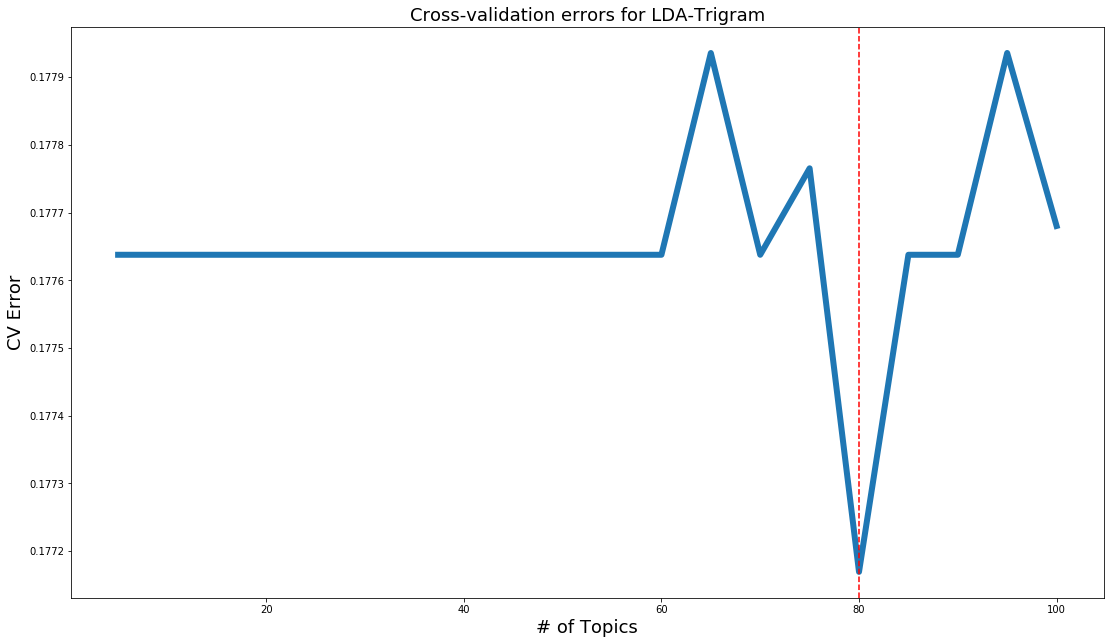

In [79]:
# Save model to disk
best_lda_tri.save(os.path.join(path_save_data,'best_lda_trigram'))
# Svae figure
plt.figure()
plt.plot(n_topics, cv_errors_tri, linewidth = 6)
plt.axvline(x = best_topic_tri, color = 'r', linestyle = '--')
plt.xlabel('# of Topics', fontsize = 18)
plt.ylabel('CV Error', fontsize = 18)
plt.title('Cross-validation errors for LDA-Trigram', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5,10.5,5)
plt.show()
fig.savefig(os.path.join(path_save_fig, 'cv_errors_trigram.png'))

In [71]:
# Save result
np.savetxt(os.path.join(path_save_data,"cv_errors_bi.csv"), cv_errors_bi, delimiter=",")

In [80]:
np.savetxt(os.path.join(path_save_data,"cv_errors_tri.csv"), cv_errors_tri, delimiter=",")